# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


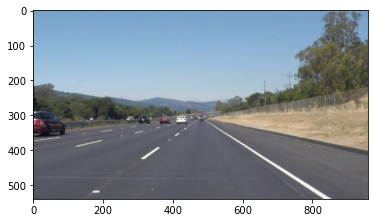

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):#OK
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)  #**++ I don't understand this
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
def draw_lines(img, lines, sety):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)"""
            
            
#######

    set_y=sety
    cont=0
    cont_positive=0
    cont_negative=0
    slope=[]
    accumulate_positive_slope=0
    accumulate_negative_slope=0
    accumulate_positive_x_high=0
    accumulate_negative_x_high=0
    acccumulate_negative_x_low=0
    acccumulate_positive_x_low=0
    accumulate_x2_positive=0
    accumulate_y2_positive=0
    accumulate_x2_negative=0
    accumulate_y2_negative=0
    imshape=img.shape# imshape[0]:number of rows imshape[1]: number of columns
    for line in lines:
        for x1,y1,x2,y2 in line:
            #slope
            if (x2-x1)!=0 :
                if(y2-y1)!=0:
                    slope.append((y2-y1)/(x2-x1))
                    m=(y2-y1)/(x2-x1)
                    b=y2-m*x2
                    #limits 
                    y_high=imshape[0]
                    x_high=int((y_high-b)/m)
                    y_low=set_y
                    x_low=int((set_y-b)/m)
                    cont=cont+1
                    #acumulate amonts
                    if m>0 and m >0.5:
                        accumulate_positive_slope=accumulate_positive_slope+m
                        accumulate_positive_x_high=accumulate_positive_x_high+x_high
                        acccumulate_positive_x_low=acccumulate_positive_x_low+x_low
                        accumulate_x2_positive=accumulate_x2_positive+x2
                        accumulate_y2_positive=accumulate_y2_positive+y2
                        cont_positive=cont_positive+1
                        
                    if m<0 and m<-0.5:
                        accumulate_negative_slope=accumulate_negative_slope+m
                        accumulate_negative_x_high=accumulate_negative_x_high+x_high
                        acccumulate_negative_x_low=acccumulate_negative_x_low+x_low
                        accumulate_x2_negative=accumulate_x2_negative+x2
                        accumulate_y2_negative=accumulate_y2_negative+y2
                        cont_negative=cont_negative+1
                    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    #cv2.line(img,(x_low,y_low),(x_high,y_high),(0,255,0),2)
                    #print('This is counter: ', cont)
    if cont_positive != 0: 
        m=accumulate_positive_slope/cont_positive
        print("This is a positive slope average::", m)
        if m>0:
            x2=accumulate_x2_positive/cont_positive
            y2=accumulate_y2_positive/cont_positive
            b=y2-m*x2
            y_high=imshape[0]
            x_high=int((y_high-b)/m)
            y_low=set_y
            x_low=int((set_y-b)/m)
            cv2.line(img,(x_low,y_low),(x_high,y_high),(0,0,255),5)
        
    if cont_negative != 0:   
        m=accumulate_negative_slope/cont_negative
        print("This is a negative slope average::", m)
        if m<0:
            x2=accumulate_x2_negative/cont_negative
            y2=accumulate_y2_negative/cont_negative
            b=y2-m*x2
            y_high=imshape[0]
            x_high=int((y_high-b)/m)
            y_low=set_y
            x_low=int((set_y-b)/m)
            cv2.line(img,(x_low,y_low),(x_high,y_high),(0,0,255),5)
        
    #print("this is slope:",slope)
    """       
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(img);       
    #cv2.line(line_image2,(lines[1][0][0],lines[1][0][1]),(lines[1][0][2],lines[1][0][3]),(0,0,255),2)  
    """
            
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,sety):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #**++I don't understand how work HuoughLinesP
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,sety) #**++ I don't understand Why draw_lines doesn't have return function?? How it works?
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
def read_image(number):
    #os.listdir("test_images/") #There are 6 images
    #Reading an image
    name=os.listdir("test_images/")[number]
    image = mpimg.imread('test_images/%s'%name)
    #plt.imshow(image)
    #print(image.shape)
    return image 

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This is a positive slope average:: 0.5722957127429024
This is a negative slope average:: -0.7989159640376392
(540, 960, 3)


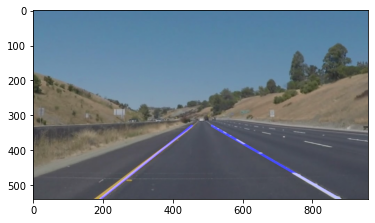

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def analyze(image):
    # RGB to Gray 
    gray = grayscale(image)
        #plt.imshow(gray, cmap='gray')

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5 #**++Why the kernel size is 5?
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50   #**++are sure about these values?
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # This time we are defining a four sided polygon to mask
    # set x and y values
    # 120 and 960 values were taken manuallyf from a picture of 540x960
    imshape = image.shape # imshape[0]:number of rows, imshape[1]: number of columns
    set_left_x=int((120/960)*imshape[1]) #this value was 70/960
    set_left_y=imshape[0] #The maximum value of y
    set_middle1_x=int((445/960)*imshape[1])  #this value was 445/960
    set_middle1_y=int((330/540)*imshape[0]) #this value was 330/540
    set_middle2_x=int((525/960)*imshape[1]) #this value was 525/960
    set_middle2_y=int((330/540)*imshape[0]) #this value was 330/540
    set_right_x=int((900/960)*imshape[1]) #this value was 950/960
    set_right_y=imshape[0]#The maximum value of y

    vertices = np.array([[(set_left_x,set_left_y),(set_middle1_x, set_middle1_y), 
                              (set_middle2_x, set_middle2_y), (set_right_x,set_right_y)]], 
                                dtype=np.int32)

    #Mask Apply
    masked_edges = region_of_interest(edges, vertices)
        #plt.imshow(masked_edges, cmap='gray')
     
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 25     # minimum number of votes (intersections in Hough grid cell)-->15
    min_line_length = 20 #minimum number of pixels making up a line-->20
    max_line_gap = 5   # maximum gap in pixels between connectable line segments-->10
    ##line_image = np.copy(image)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments

    #lines_image=hough_lines(masked_edges,rho,theta,threshold,min_line_length, max_line_gap,set_middle1_y)
    lines_image=hough_lines(masked_edges,rho,theta,threshold,min_line_length, max_line_gap,set_middle1_y)
    """
    #+++Proofs
    #plt.imshow(lines_image)
    fig, ax = plt.subplots(1,2)
    #ax[0].imshow(blur_gray);
    ax[0].imshow(lines_image);
    ax[1].imshow(edges);"""


    # Draw the lines on the edge image
    #Original_image + lines
    #original_image_with_lines = weighted_img(lines_image, image,α=0.8, β=1, γ=0) 
    original_image_with_lines = weighted_img(lines_image, image,α=0.8, β=1, γ=0) 
    return original_image_with_lines

image=read_image(5)
line_detected=analyze(image)
print(line_detected.shape)
plt.imshow(line_detected)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    result=analyze(image)
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This is a positive slope average:: 0.6100200322173236
This is a negative slope average:: -0.7162578492935637
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



t:   0%|          | 0/125 [00:00<?, ?it/s, now=None]

This is a positive slope average:: 0.6100200322173236
This is a negative slope average:: -0.7162578492935637


t:   6%|▋         | 8/125 [00:00<00:08, 14.45it/s, now=None]

This is a positive slope average:: 0.6113152099373435
This is a negative slope average:: -0.7394445594789928
This is a positive slope average:: 0.6193087150666725
This is a negative slope average:: -0.7021847200418629
This is a positive slope average:: 0.602417190213421
This is a negative slope average:: -0.7410507213638144
This is a positive slope average:: 0.603556131011591
This is a negative slope average:: -0.7482413419913421
This is a positive slope average:: 0.59655656428858
This is a negative slope average:: -0.7290733957400625
This is a positive slope average:: 0.6049220258599298
This is a negative slope average:: -0.6976958525345622
This is a positive slope average:: 0.6104362659053794
This is a negative slope average:: -0.6981238634897171
This is a positive slope average:: 0.6033687702753839
This is a negative slope average:: -0.7203516220848861
This is a positive slope average:: 0.5957706742218655
This is a negative slope average:: -0.7025053207661904
This is a positive slop

t:  17%|█▋        | 21/125 [00:00<00:02, 34.71it/s, now=None]

This is a negative slope average:: -0.7089134914932788
This is a positive slope average:: 0.6300880926076234
This is a negative slope average:: -0.7248109559546929
This is a positive slope average:: 0.631625468974998
This is a negative slope average:: -0.69639649354153
This is a positive slope average:: 0.6565807726549403
This is a negative slope average:: -0.6917634059505707
This is a positive slope average:: 0.6536955697310497
This is a negative slope average:: -0.6956521739130435
This is a positive slope average:: 0.6421927036573971
This is a negative slope average:: -0.698005698005698
This is a positive slope average:: 0.6338461715007133
This is a negative slope average:: -0.6733664021164021
This is a positive slope average:: 0.6398444750118193
This is a negative slope average:: -0.722561897269906
This is a positive slope average:: 0.6332646087656187
This is a negative slope average:: -0.713804292170351
This is a positive slope average:: 0.6467551097669948
This is a negative slope 

t:  28%|██▊       | 35/125 [00:01<00:01, 51.19it/s, now=None]

This is a negative slope average:: -0.7266449654046085
This is a positive slope average:: 0.638399988630786
This is a negative slope average:: -0.709075537098777
This is a positive slope average:: 0.6201140829431632
This is a negative slope average:: -0.6831599653469969
This is a positive slope average:: 0.6376460287841728
This is a negative slope average:: -0.6902173913043478
This is a positive slope average:: 0.6374865609044649
This is a negative slope average:: -0.7115215372111924
This is a positive slope average:: 0.6379568425923343
This is a negative slope average:: -0.6918347777982666
This is a positive slope average:: 0.6340872173075589
This is a negative slope average:: -0.7002923976608186
This is a positive slope average:: 0.6342179030626379
This is a negative slope average:: -0.7275003226222738
This is a positive slope average:: 0.641505750466522
This is a negative slope average:: -0.7118863488495889
This is a positive slope average:: 0.6390436881999698
This is a negative slo

t:  34%|███▍      | 43/125 [00:01<00:01, 58.26it/s, now=None]

This is a negative slope average:: -0.7223462301587302
This is a positive slope average:: 0.654270098980765
This is a negative slope average:: -0.7005634763786938
This is a positive slope average:: 0.6671853090806315
This is a negative slope average:: -0.7234195402298851
This is a positive slope average:: 0.6723934006326676
This is a negative slope average:: -0.7118055555555555
This is a positive slope average:: 0.6459972586096133
This is a negative slope average:: -0.7038527691778467
This is a positive slope average:: 0.6690306714859164
This is a negative slope average:: -0.7238264099966227
This is a positive slope average:: 0.6601773436191768
This is a negative slope average:: -0.7081399509597801
This is a positive slope average:: 0.6679826417767765
This is a negative slope average:: -0.7038979543173374
This is a positive slope average:: 0.652759045907874


t:  45%|████▍     | 56/125 [00:01<00:01, 51.44it/s, now=None]

This is a negative slope average:: -0.7059167893038861
This is a positive slope average:: 0.6672905637336408
This is a negative slope average:: -0.7393216606552933
This is a positive slope average:: 0.6637283517767346
This is a negative slope average:: -0.735397635739416
This is a positive slope average:: 0.6398529789143623
This is a negative slope average:: -0.7122217049958235
This is a positive slope average:: 0.6536501473817834
This is a negative slope average:: -0.7117050796926958
This is a positive slope average:: 0.6456847752169245
This is a negative slope average:: -0.727152709359606
This is a positive slope average:: 0.6446063426697958
This is a negative slope average:: -0.7307692307692307
This is a positive slope average:: 0.6349444829117961
This is a negative slope average:: -0.7330367074527253
This is a positive slope average:: 0.6400755514219362
This is a negative slope average:: -0.6597222222222222
This is a positive slope average:: 0.6606878667709395
This is a negative sl

t:  50%|████▉     | 62/125 [00:01<00:01, 47.95it/s, now=None]

This is a negative slope average:: -0.6703924162257495
This is a positive slope average:: 0.6491885717158161
This is a negative slope average:: -0.7022148016430954
This is a positive slope average:: 0.6691591980437939
This is a negative slope average:: -0.6662860807441503
This is a positive slope average:: 0.6624993684498393
This is a negative slope average:: -0.6837770274909865
This is a positive slope average:: 0.6322155093104713


t:  54%|█████▍    | 68/125 [00:01<00:01, 38.74it/s, now=None]

This is a negative slope average:: -0.6874079789258359
This is a positive slope average:: 0.6576740814098384
This is a negative slope average:: -0.6541062801932367
This is a positive slope average:: 0.6585675274688708
This is a negative slope average:: -0.6794871794871795
This is a positive slope average:: 0.6483470257786104
This is a negative slope average:: -0.6787096774193548
This is a positive slope average:: 0.6712693688285599
This is a negative slope average:: -0.6857142857142857
This is a positive slope average:: 0.654709544286195
This is a negative slope average:: -0.6949910554561718
This is a positive slope average:: 0.6622813811941538
This is a negative slope average:: -0.70076726342711
This is a positive slope average:: 0.6583536827102157
This is a negative slope average:: -0.7016653655997918
This is a positive slope average:: 0.6746594185558543
This is a negative slope average:: -0.697008547008547
This is a positive slope average::

t:  63%|██████▎   | 79/125 [00:02<00:01, 38.59it/s, now=None]

 0.6609755655213436
This is a negative slope average:: -0.6758058209038601
This is a positive slope average:: 0.6722659830322228
This is a negative slope average:: -0.6766665994310773
This is a positive slope average:: 0.6541759157928576
This is a negative slope average:: -0.6793817965188241
This is a positive slope average:: 0.663433462675564
This is a negative slope average:: -0.6852925389157273
This is a positive slope average:: 0.6587847064381722
This is a negative slope average:: -0.6731538992408557
This is a positive slope average:: 0.6525003739073848
This is a negative slope average:: -0.6428571428571429
This is a positive slope average:: 0.6591743411240268
This is a negative slope average:: -0.6407624633431085
This is a positive slope average:: 0.6805759847035018
This is a negative slope average:: -0.6538461538461539
This is a positive slope average:: 0.6721818795133909


t:  68%|██████▊   | 85/125 [00:02<00:00, 42.21it/s, now=None]

This is a negative slope average:: -0.6666666666666666
This is a positive slope average:: 0.6718030852912276
This is a negative slope average:: -0.7
This is a positive slope average:: 0.6948490439219354
This is a negative slope average:: -0.675
This is a positive slope average:: 0.6913842422476646
This is a negative slope average:: -0.6748493975903614
This is a positive slope average:: 0.6865060339935478
This is a negative slope average:: -0.6666666666666666
This is a positive slope average:: 0.6792100212445406
This is a negative slope average:: -0.6702127659574468
This is a positive slope average:: 0.7139030507425401
This is a negative slope average:: -0.6756548536209552
This is a positive slope average:: 0.6848927403140086


t:  72%|███████▏  | 90/125 [00:02<00:01, 34.72it/s, now=None]

This is a negative slope average:: -0.6586666119186444
This is a positive slope average:: 0.6924620536871299
This is a negative slope average:: -0.671528326745718
This is a positive slope average:: 0.695188356101533
This is a negative slope average:: -0.6666666666666666
This is a positive slope average:: 0.7048844934723459
This is a negative slope average:: -0.6534090909090908
This is a positive slope average:: 0.678396850181907
This is a negative slope average:: -0.6606606606606605
This is a positive slope average:: 0.72135678918333


t:  80%|████████  | 100/125 [00:02<00:00, 38.59it/s, now=None]

This is a negative slope average:: -0.6699346405228758
This is a positive slope average:: 0.7085272244713529
This is a negative slope average:: -0.6817765567765568
This is a positive slope average:: 0.719191221783256
This is a negative slope average:: -0.6869239631336406
This is a positive slope average:: 0.6866733792347971
This is a negative slope average:: -0.6713615023474178
This is a positive slope average:: 0.71515575858413
This is a negative slope average:: -0.708236970001676
This is a positive slope average:: 0.7166584615748632
This is a negative slope average:: -0.6707601660606999
This is a positive slope average:: 0.6908134909886866
This is a negative slope average:: -0.6880626163189344
This is a positive slope average:: 0.7092033244677344
This is a negative slope average:: -0.6825757575757576
This is a positive slope average:: 0.6864762308974617
This is a negative slope average:: -0.6464728682170543


t:  84%|████████▍ | 105/125 [00:02<00:00, 37.23it/s, now=None]

This is a positive slope average:: 0.6928728316116609
This is a negative slope average:: -0.6794871794871795
This is a positive slope average:: 0.6820626168162033
This is a negative slope average:: -0.6353535353535352
This is a positive slope average:: 0.6874091239272578
This is a negative slope average:: -0.6899656750572083
This is a positive slope average:: 0.6727027022335509
This is a negative slope average:: -0.663723544973545
This is a positive slope average:: 0.6623409487013697
This is a negative slope average:: -0.6865759039672084
This is a positive slope average:: 0.6522604908351817
This is a negative slope average:: -0.6747212125707787
This is a positive slope average:: 0.6761235487671055
This is a negative slope average:: -0.6817634186941385
This is a positive slope average:: 0.6794464309174697
This is a negative slope average:: -0.6768371797466273


t:  92%|█████████▏| 115/125 [00:03<00:00, 37.00it/s, now=None]

This is a positive slope average:: 0.6789946723294672
This is a negative slope average:: -0.6644651407775607
This is a positive slope average:: 0.6907850487443555
This is a negative slope average:: -0.6681662425578355
This is a positive slope average:: 0.683745581885215
This is a negative slope average:: -0.6843542105791055
This is a positive slope average:: 0.6891402033530055
This is a negative slope average:: -0.6886444102710823
This is a positive slope average:: 0.6776572528954705
This is a negative slope average:: -0.6797008547008546
This is a positive slope average:: 0.6765192012716228
This is a negative slope average:: -0.6774193548387096
This is a positive slope average:: 0.7035072780200042
This is a negative slope average:: -0.6857142857142857
This is a positive slope average:: 0.6572965434358279
This is a negative slope average:: -0.6601498859563376
This is a positive slope average:: 0.6491070966542903
This is a negative slope average:: -0.680608164983165
This is a positive sl

This is a positive slope average:: 0.6673224699652528
This is a negative slope average:: -0.6746507119256887
This is a positive slope average:: 0.6504685181295298
This is a negative slope average:: -0.686733998593283
This is a positive slope average:: 0.6389330181551801
This is a negative slope average:: -0.6660238656585792
This is a positive slope average:: 0.6676129786026247
This is a negative slope average:: -0.6677688212170972
This is a positive slope average:: 0.6255217686827549
This is a negative slope average:: -0.6841252835041656
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 4.45 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This is a positive slope average:: 0.6620451982997668
This is a negative slope average:: -0.6434173241840738
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

This is a positive slope average:: 0.6620451982997668
This is a negative slope average:: -0.6434173241840738


t:   1%|▏         | 9/681 [00:00<00:43, 15.34it/s, now=None]

This is a positive slope average:: 0.6544662309368192
This is a negative slope average:: -0.6365445145065962
This is a positive slope average:: 0.6830125449019067
This is a negative slope average:: -0.6336785973773761
This is a positive slope average:: 0.6607267067272313
This is a negative slope average:: -0.6646301063665387
This is a positive slope average:: 0.6548929512516469
This is a negative slope average:: -0.6213907198370624
This is a positive slope average:: 0.682081807081807
This is a negative slope average:: -0.6403821111670477
This is a positive slope average:: 0.6585497835497836
This is a negative slope average:: -0.6526922801267572
This is a positive slope average:: 0.6593417366946779
This is a negative slope average:: -0.6384589666420996
This is a positive slope average:: 0.6328455495122162
This is a negative slope average:: -0.6780679108342218
This is a positive slope average:: 0.6434514361300077
This is a negative slope average:: -0.6502608562852863
This is a positive s

t:   4%|▎         | 25/681 [00:00<00:16, 39.17it/s, now=None]

This is a positive slope average:: 0.6519884702153306
This is a negative slope average:: -0.6797312342998556
This is a positive slope average:: 0.6230672211416554
This is a negative slope average:: -0.6878921946385954
This is a positive slope average:: 0.6466901861626494
This is a negative slope average:: -0.6625177579650151
This is a positive slope average:: 0.6203296703296703
This is a negative slope average:: -0.6937093410956157
This is a positive slope average:: 0.6459694989106755
This is a negative slope average:: -0.6879995491558175
This is a positive slope average:: 0.6088073719652667
This is a negative slope average:: -0.6969701494453677
This is a positive slope average:: 0.6347222222222222
This is a negative slope average:: -0.6911734643445469
This is a positive slope average:: 0.6273849014346384
This is a negative slope average:: -0.711733065389607
This is a positive slope average:: 0.6474877976136205
This is a negative slope average:: -0.7132155085626279
This is a positive s

t:   6%|▌         | 39/681 [00:01<00:12, 51.71it/s, now=None]

This is a negative slope average:: -0.710618976352772
This is a positive slope average:: 0.5996094416335516
This is a negative slope average:: -0.7094597653228158
This is a positive slope average:: 0.6002976190476191
This is a negative slope average:: -0.7094333844102356
This is a positive slope average:: 0.6110739750445633
This is a negative slope average:: -0.7230347983270369
This is a positive slope average:: 0.6011904761904763
This is a negative slope average:: -0.7372047322075086
This is a positive slope average:: 0.601123053437219
This is a negative slope average:: -0.7157728534838257
This is a positive slope average:: 0.6241221741221742
This is a negative slope average:: -0.7328818024217097
This is a positive slope average:: 0.6079497336166543
This is a negative slope average:: -0.7294227444342616
This is a positive slope average:: 0.6170239710538218
This is a negative slope average:: -0.7266433017707762
This is a positive slope average:: 0.595696067185254
This is a negative slo

t:   7%|▋         | 47/681 [00:01<00:10, 58.26it/s, now=None]

0.5842679727842152
This is a negative slope average:: -0.7399897428355074
This is a positive slope average:: 0.6035714285714285
This is a negative slope average:: -0.7354008691639635
This is a positive slope average:: 0.5732323232323233
This is a negative slope average:: -0.7554570364458633
This is a positive slope average:: 0.6015873015873016
This is a negative slope average:: -0.7196621937692294
This is a positive slope average:: 0.6156808688387636
This is a negative slope average:: -0.73008151762646
This is a positive slope average:: 0.6164641623840988
This is a negative slope average:: -0.7379459545940539
This is a positive slope average:: 0.6263792819499341
This is a negative slope average:: -0.7445725016289694
This is a positive slope average:: 0.6085678422634945


t:   9%|▉         | 60/681 [00:01<00:12, 49.39it/s, now=None]

This is a negative slope average:: -0.7279849234568039
This is a positive slope average:: 0.6214672950934716
This is a negative slope average:: -0.7519041644975
This is a positive slope average:: 0.6068719131866349
This is a negative slope average:: -0.7392718488803721
This is a positive slope average:: 0.5955641378014505
This is a negative slope average:: -0.7358545857186212
This is a positive slope average:: 0.5854121400402956
This is a negative slope average:: -0.729502146311201
This is a positive slope average:: 0.5865049204708673
This is a negative slope average:: -0.7259003013328896
This is a positive slope average:: 0.6114408984149393
This is a negative slope average:: -0.727381404174573
This is a positive slope average:: 0.6170329670329671
This is a negative slope average:: -0.7204826144815382
This is a positive slope average:: 0.6145867542419267
This is a negative slope average:: -0.734931581274522
This is a positive slope average:: 0.613042048133326
This is a negative slope a

t:  10%|▉         | 66/681 [00:01<00:14, 41.87it/s, now=None]

This is a positive slope average:: 0.6280801209372637
This is a negative slope average:: -0.7155811993277514
This is a positive slope average:: 0.6192272199795069
This is a negative slope average:: -0.7023921158297399
This is a positive slope average:: 0.6137027937027937
This is a negative slope average:: -0.678573204223067
This is a positive slope average:: 0.6139717015569344
This is a negative slope average:: -0.6978733047643162
This is a positive slope average:: 0.6085842272529381
This is a negative slope average:: -0.7029288612621946
This is a positive slope average:: 0.5908075464889478
This is a negative slope average:: -0.704672722697999


t:  11%|█         | 72/681 [00:01<00:14, 43.02it/s, now=None]

This is a positive slope average:: 0.6128844941274861
This is a negative slope average:: -0.688694490815678
This is a positive slope average:: 0.6062474947638307
This is a negative slope average:: -0.7181449309870392
This is a positive slope average:: 0.6115181115181115
This is a negative slope average:: -0.6721331874385389
This is a positive slope average:: 0.6467074592074592
This is a negative slope average:: -0.690503254905377
This is a positive slope average:: 0.630753921001599
This is a negative slope average:: -0.6874504625864231
This is a positive slope average:: 0.6353418346359523
This is a negative slope average:: -0.7242159624902171
This is a positive slope average:: 0.6316644892372776
This is a negative slope average:: -0.746135877416447
This is a positive slope average:: 0.6416307471264368
This is a negative slope average:: -0.7018942825707484
This is a positive slope average:: 0.6467777777777778
This is a negative slope average:: -0.7029344356262905
This is a positive slop

t:  12%|█▏        | 84/681 [00:02<00:13, 45.15it/s, now=None]

This is a negative slope average:: -0.7024020703188676
This is a positive slope average:: 0.6045871777593476
This is a negative slope average:: -0.7070153766955707
This is a positive slope average:: 0.6199327949311597
This is a negative slope average:: -0.687600704084059
This is a positive slope average:: 0.6135510622121211
This is a negative slope average:: -0.717171313610802
This is a positive slope average:: 0.6102415168464742
This is a negative slope average:: -0.6962825163114522
This is a positive slope average:: 0.6322823483759301
This is a negative slope average:: -0.7166440793837645
This is a positive slope average:: 0.6642528735632184
This is a negative slope average:: -0.7327434458775491
This is a positive slope average:: 0.638425925925926
This is a negative slope average:: -0.718189387566009
This is a positive slope average:: 0.6458934583934584
This is a negative slope average:: -0.7221144559590623


t:  13%|█▎        | 89/681 [00:02<00:15, 39.17it/s, now=None]

This is a positive slope average:: 0.6604142469996128
This is a negative slope average:: -0.7080874154210919
This is a positive slope average:: 0.6301960784313725
This is a negative slope average:: -0.703921078921079
This is a positive slope average:: 0.6397273798997938
This is a negative slope average:: -0.70152127161798
This is a positive slope average:: 0.6845681310498882
This is a negative slope average:: -0.7214253586276759
This is a positive slope average:: 0.6253714657180004
This is a negative slope average:: -0.6931896227222305
This is a positive slope average:: 0.6275964382890639
This is a negative slope average:: -0.6970642738703472
This is a positive slope average::

t:  14%|█▍        | 94/681 [00:02<00:14, 39.39it/s, now=None]

 0.6475560201360647
This is a negative slope average:: -0.6840387575994176
This is a positive slope average:: 0.6432602254743865
This is a negative slope average:: -0.6913593229941669
This is a positive slope average:: 0.6416309717551953
This is a negative slope average:: -0.6796858175707176
This is a positive slope average:: 0.6288056713141602
This is a negative slope average:: -0.69924220035994
This is a positive slope average:: 0.6314102564102564
This is a negative slope average:: -0.6987355930152886
This is a positive slope average:: 0.6414677276746242
This is a negative slope average:: -0.6797430630777086
This is a positive slope average:: 0.6417994281045751
This is a negative slope average:: -0.6823432203363919


t:  15%|█▌        | 104/681 [00:02<00:14, 39.28it/s, now=None]

This is a positive slope average:: 0.6474865047233468
This is a negative slope average:: -0.6987898093175866
This is a positive slope average:: 0.6327201805286912
This is a negative slope average:: -0.7243905594231373
This is a positive slope average:: 0.6491675617615467
This is a negative slope average:: -0.7197035805241341
This is a positive slope average:: 0.6550159262140829
This is a negative slope average:: -0.7142908425841036
This is a positive slope average:: 0.6474917153128064
This is a negative slope average:: -0.7011259760879596
This is a positive slope average:: 0.6213332006435455
This is a negative slope average:: -0.693877992876006
This is a positive slope average:: 0.6300098916502294
This is a negative slope average:: -0.7004360975131734
This is a positive slope average:: 0.6364040157076216
This is a negative slope average:: -0.71617198697437
This is a positive slope average:: 0.6391609735851457
This is a negative slope average:: -0.7001922411874738
This is a positive slo

t:  17%|█▋        | 115/681 [00:02<00:13, 43.24it/s, now=None]

This is a negative slope average:: -0.6931803959521363
This is a positive slope average:: 0.6285434995112414
This is a negative slope average:: -0.6803087015477101
This is a positive slope average:: 0.6534231897135122
This is a negative slope average:: -0.6985747226727579
This is a positive slope average:: 0.6326765188834155
This is a negative slope average:: -0.6862461989836519
This is a positive slope average:: 0.6261056644880174
This is a negative slope average:: -0.6897674068973988
This is a positive slope average:: 0.6241376383364213
This is a negative slope average:: -0.6836655145693341
This is a positive slope average:: 0.6393245987553227
This is a negative slope average:: -0.696497744194021
This is a positive slope average:: 0.6487411452282646
This is a negative slope average:: -0.709332903869798
This is a positive slope average:: 0.6485540325456512


t:  18%|█▊        | 121/681 [00:03<00:11, 46.83it/s, now=None]

This is a negative slope average:: -0.6882918111171081
This is a positive slope average:: 0.6237245396063683
This is a negative slope average:: -0.6930914815754323
This is a positive slope average:: 0.6334782905435079
This is a negative slope average:: -0.6809857529712171
This is a positive slope average:: 0.638371033039448
This is a negative slope average:: -0.6843589296378472
This is a positive slope average:: 0.6235958485958485
This is a negative slope average:: -0.7031702106145951
This is a positive slope average:: 0.6506810897435897
This is a negative slope average:: -0.7272569904591633
This is a positive slope average:: 0.647943376068376
This is a negative slope average:: -0.7172398748615768
This is a positive slope average:: 0.6410613271078388
This is a negative slope average:: -0.6815099616021885
This is a positive slope average:: 0.6165947762083557
This is a negative slope average:: -0.7198360024732025
This is a positive slope average:: 0.6364337568058076


t:  19%|█▊        | 126/681 [00:03<00:20, 27.22it/s, now=None]

This is a negative slope average:: -0.7051428094163419
This is a positive slope average:: 0.6262290862290862
This is a negative slope average:: -0.7261946715545939
This is a positive slope average:: 0.642702668195279
This is a negative slope average:: -0.6746782854990183
This is a positive slope average:: 0.6201001742160279
This is a negative slope average:: -0.6936317651508416
This is a positive slope average:: 0.6228004900326675
This is a negative slope average:: -0.6937305112779438


t:  20%|█▉        | 134/681 [00:03<00:21, 25.85it/s, now=None]

This is a positive slope average:: 0.6325288058046679
This is a negative slope average:: -0.7197861846427481
This is a positive slope average:: 0.6046273479606814
This is a negative slope average:: -0.7264133656710362
This is a positive slope average:: 0.6265949888620695
This is a negative slope average:: -0.6864267248818798
This is a positive slope average:: 0.6310321606873331
This is a negative slope average:: -0.7137630170041429
This is a positive slope average:: 0.6285239491691104
This is a negative slope average:: -0.7189527507190304
This is a positive slope average:: 0.6313236313236313
This is a negative slope average:: -0.6710868777795214
This is a positive slope average:: 0.6317254488879204
This is a negative slope average:: -0.6999020082596974
This is a positive slope average:: 0.6230140572968301
This is a negative slope average:: -0.6973525457426356
This is a positive slope average:: 0.6408367902838865


t:  20%|██        | 139/681 [00:03<00:17, 30.41it/s, now=None]

This is a negative slope average:: -0.6828898454802769
This is a positive slope average:: 0.6412806983258419
This is a negative slope average:: -0.7101393624995057
This is a positive slope average:: 0.6351960390739997
This is a negative slope average:: -0.7197920623418719
This is a positive slope average:: 0.628626938205697
This is a negative slope average:: -0.6754474156518844


t:  21%|██        | 143/681 [00:04<00:24, 21.81it/s, now=None]

This is a positive slope average:: 0.6118388139932429
This is a negative slope average:: -0.7196636041080685
This is a positive slope average:: 0.6223117297159272
This is a negative slope average:: -0.7119424830997777
This is a positive slope average:: 0.6094814803543146
This is a negative slope average:: -0.7158446053208931
This is a positive slope average:: 0.617624521072797
This is a negative slope average:: -0.6867288596228215
This is a positive slope average:: 0.6333333333333333


t:  22%|██▏       | 148/681 [00:04<00:20, 25.61it/s, now=None]

This is a negative slope average:: -0.7074503739940009
This is a positive slope average:: 0.6115354206198609
This is a negative slope average:: -0.7044084028687577
This is a positive slope average:: 0.6106182948221488
This is a negative slope average:: -0.698702734342156
This is a positive slope average:: 0.6255718954248366
This is a negative slope average:: -0.6893980873596283
This is a positive slope average:: 0.6218257105213627
This is a negative slope average:: -0.7123655360840151
This is a positive slope average:: 0.6165454907010288
This is a negative slope average:: -0.6787247832730866
This is a positive slope average::

t:  22%|██▏       | 152/681 [00:04<00:20, 25.98it/s, now=None]

 0.621078921078921
This is a negative slope average:: -0.7043591554313213
This is a positive slope average:: 0.6097974357206998
This is a negative slope average:: -0.6791401771998925
This is a positive slope average:: 0.6215739316244647
This is a negative slope average:: -0.6849089464035795
This is a positive slope average:: 0.6084195254952821
This is a negative slope average:: -0.6976272771612764
This is a positive slope average:: 0.605700250021791
This is a negative slope average:: -0.709920664257883


t:  23%|██▎       | 159/681 [00:05<00:28, 18.63it/s, now=None]

This is a positive slope average:: 0.591468253968254
This is a negative slope average:: -0.7019249013984252
This is a positive slope average:: 0.5806596768081751
This is a negative slope average:: -0.6903234958568688
This is a positive slope average:: 0.5764074569221628
This is a negative slope average:: -0.7101388324302012
This is a positive slope average:: 0.5923109054688002
This is a negative slope average:: -0.6926517277484624


t:  25%|██▍       | 168/681 [00:05<00:20, 25.57it/s, now=None]

This is a positive slope average:: 0.5942268150879183
This is a negative slope average:: -0.7054645522617533
This is a positive slope average:: 0.6031528964862298
This is a negative slope average:: -0.719455672430126
This is a positive slope average:: 0.579657258372475
This is a negative slope average:: -0.735155952995217
This is a positive slope average:: 0.5918490004528693
This is a negative slope average:: -0.7397708313965833
This is a positive slope average:: 0.6059897292250234
This is a negative slope average:: -0.7073084656855151
This is a positive slope average:: 0.5936042684140422
This is a negative slope average:: -0.7237774595647544
This is a positive slope average:: 0.5926248493759556
This is a negative slope average:: -0.722565400114326
This is a positive slope average:: 0.573557142425067
This is a negative slope average:: -0.7060968695874357
This is a positive slope average:: 0.5907468831890393
This is a negative slope average:: -0.7235580387389761
This is a positive slope

t:  26%|██▌       | 177/681 [00:05<00:15, 32.47it/s, now=None]

This is a negative slope average:: -0.7446616594266695
This is a positive slope average:: 0.5671896194759762
This is a negative slope average:: -0.7194025723388183
This is a positive slope average:: 0.590134459036898
This is a negative slope average:: -0.7471528677573723
This is a positive slope average:: 0.5743856837606838
This is a negative slope average:: -0.723139655782684
This is a positive slope average:: 0.5736725105189341
This is a negative slope average:: -0.7643624801610706
This is a positive slope average:: 0.5619708994708995
This is a negative slope average:: -0.7447143046584878
This is a positive slope average:: 0.574828929240694
This is a negative slope average:: -0.7439564368122876
This is a positive slope average:: 0.574164393383172

t:  27%|██▋       | 183/681 [00:05<00:13, 37.92it/s, now=None]


This is a negative slope average:: -0.7651629149402591
This is a positive slope average:: 0.5592364895224314
This is a negative slope average:: -0.7612287081247199
This is a positive slope average:: 0.5588688115357444
This is a negative slope average:: -0.7567843253502168
This is a positive slope average:: 0.5738240920509632
This is a negative slope average:: -0.7582537092415574
This is a positive slope average:: 0.5568785845172652
This is a negative slope average:: -0.7449273397203345
This is a positive slope average:: 0.5367063492063492
This is a negative slope average:: -0.7418764161291076
This is a positive slope average:: 0.5594631740641928
This is a negative slope average:: -0.7566039833532784
This is a positive slope average:: 0.5591353091353091
This is a negative slope average:: -0.7591743652930784


t:  28%|██▊       | 188/681 [00:05<00:15, 32.79it/s, now=None]

This is a positive slope average:: 0.5529954866562009
This is a negative slope average:: -0.7882278769510351
This is a positive slope average:: 0.5659723658379414
This is a negative slope average:: -0.7565289464188815
This is a positive slope average:: 0.564204086302525
This is a negative slope average:: -0.756579508820776
This is a positive slope average:: 0.5805797377975483
This is a negative slope average:: -0.7927659496230764
This is a positive slope average:: 0.5565385007708501
This is a negative slope average:: -0.752103859968304
This is a positive slope average:: 0.5419131159677378
This is a negative slope average:: -0.7619850179594903
This is a positive slope average:: 0.5507094590035427
This is a negative slope average:: -0.7549169166234628
This is a positive slope average:: 0.5563596935937362
This is a negative slope average:: -0.7489686084857533
This is a positive slope average:: 0.5560259879009879


t:  29%|██▉       | 199/681 [00:06<00:12, 39.37it/s, now=None]

This is a negative slope average:: -0.767260428380589
This is a positive slope average:: 0.5623342175066313
This is a negative slope average:: -0.7770939011751834
This is a positive slope average:: 0.5593073593073593
This is a negative slope average:: -0.7967288867015103
This is a positive slope average:: 0.5569316648264017
This is a negative slope average:: -0.7882450718210597
This is a positive slope average:: 0.5589569160997733
This is a negative slope average:: -0.7893183278799903
This is a positive slope average:: 0.568035426731079
This is a negative slope average:: -0.78148299009361
This is a positive slope average:: 0.5636565087991718
This is a negative slope average:: -0.7459139871802914
This is a positive slope average:: 0.5633173677129555
This is a negative slope average:: -0.7620242083723433
This is a positive slope average:: 0.5606429147081625
This is a negative slope average:: -0.7635785438362613
This is a positive slope average:: 0.5717402883589265


t:  31%|███       | 211/681 [00:06<00:10, 44.93it/s, now=None]

This is a negative slope average:: -0.7742472148448303
This is a positive slope average:: 0.5559204636981144
This is a negative slope average:: -0.7706952692889149
This is a positive slope average:: 0.5600336356200367
This is a negative slope average:: -0.7830667270706482
This is a positive slope average:: 0.5611395603642217
This is a negative slope average:: -0.7501074114305315
This is a positive slope average:: 0.5692914254204577
This is a negative slope average:: -0.7742683899207298
This is a positive slope average:: 0.5326490713587487
This is a negative slope average:: -0.7290614025516329
This is a positive slope average:: 0.5786754496431916
This is a negative slope average:: -0.7411493717696113
This is a positive slope average:: 0.574457496526462
This is a negative slope average:: -0.7574080722945605
This is a positive slope average:: 0.5733658364518048
This is a negative slope average:: -0.767211534237358
This is a positive slope average:: 0.5884951013898382


t:  32%|███▏      | 218/681 [00:06<00:09, 49.38it/s, now=None]

This is a negative slope average:: -0.7354062655239488
This is a positive slope average:: 0.5836896598090627
This is a negative slope average:: -0.7759297388641364
This is a positive slope average:: 0.5689469252014914
This is a negative slope average:: -0.759215588543463
This is a positive slope average:: 0.5726129870167966
This is a negative slope average:: -0.7449791299857842
This is a positive slope average:: 0.5711464049914654
This is a negative slope average:: -0.7437072420265698
This is a positive slope average:: 0.5750392235087601
This is a negative slope average:: -0.763347717838096
This is a positive slope average:: 0.5704478358463866
This is a negative slope average:: -0.7085100863724221
This is a positive slope average:: 0.5921960058544726
This is a negative slope average:: -0.7384026955021981
This is a positive slope average:: 0.5946286472148541
This is a negative slope average:: -0.7222995759823146
This is a positive slope average:: 0.5803079284221525
This is a negative sl

t:  34%|███▍      | 230/681 [00:06<00:08, 52.95it/s, now=None]

This is a negative slope average:: -0.7095396081561905
This is a positive slope average:: 0.6017104516225095
This is a negative slope average:: -0.7161381264347809
This is a positive slope average:: 0.6034823972323973
This is a negative slope average:: -0.7278048603919118
This is a positive slope average:: 0.5959537241470014
This is a negative slope average:: -0.7196653545003616
This is a positive slope average:: 0.6006062121591004
This is a negative slope average:: -0.7426657538158233
This is a positive slope average:: 0.5886107008313595
This is a negative slope average:: -0.7464788527780519
This is a positive slope average:: 0.5786808174571269
This is a negative slope average:: -0.7181837065140759
This is a positive slope average:: 0.5921981603843935
This is a negative slope average:: -0.7329043243108935
This is a positive slope average:: 0.5950372237456923
This is a negative slope average:: -0.7493121528624408
This is a positive slope average:: 0.5950805152979066
This is a negative 

t:  36%|███▌      | 243/681 [00:06<00:07, 56.54it/s, now=None]

This is a negative slope average:: -0.7375892197240106
This is a positive slope average:: 0.5888570802153644
This is a negative slope average:: -0.7176660992175793
This is a positive slope average:: 0.6070626477541371
This is a negative slope average:: -0.6990181126776196
This is a positive slope average:: 0.594327485380117
This is a negative slope average:: -0.7164345140724215
This is a positive slope average:: 0.605185987721199
This is a negative slope average:: -0.704099965565622
This is a positive slope average:: 0.59605593952847
This is a negative slope average:: -0.7039107175564063
This is a positive slope average:: 0.6131805120880324
This is a negative slope average:: -0.7116267854511257
This is a positive slope average:: 0.593412005554573
This is a negative slope average:: -0.7159432728895341
This is a positive slope average:: 0.5916740399385559
This is a negative slope average:: -0.7156037105282919
This is a positive slope average:: 0.5893819231650315
This is a negative slope 

t:  37%|███▋      | 250/681 [00:06<00:07, 59.95it/s, now=None]

This is a negative slope average:: -0.6937249152586029
This is a positive slope average:: 0.5856684981684981
This is a negative slope average:: -0.7188451432386327
This is a positive slope average:: 0.5685838443275515
This is a negative slope average:: -0.7336341313300658
This is a positive slope average:: 0.611113403905546
This is a negative slope average:: -0.697004970522277
This is a positive slope average:: 0.5886332581813214
This is a negative slope average:: -0.7383099397241205
This is a positive slope average:: 0.6071349061786221
This is a negative slope average:: -0.7560021657410911
This is a positive slope average:: 0.5933665322497026
This is a negative slope average:: -0.6922745467312018
This is a positive slope average:: 0.5984349202566766
This is a negative slope average:: -0.7108166042972972
This is a positive slope average:: 0.5976211115394124
This is a negative slope average:: -0.7119355977319852
This is a positive slope average:: 0.6094276700128579
This is a negative sl

t:  39%|███▉      | 265/681 [00:07<00:06, 63.18it/s, now=None]

This is a negative slope average:: -0.7275838016694163
This is a positive slope average:: 0.5736120696265624
This is a negative slope average:: -0.7336652698117362
This is a positive slope average:: 0.5874431526605439
This is a negative slope average:: -0.7222725457603358
This is a positive slope average:: 0.6021370546398355
This is a negative slope average:: -0.7277765185214695
This is a positive slope average:: 0.6097755725364834
This is a negative slope average:: -0.7402920649580927
This is a positive slope average:: 0.5882770562770563
This is a negative slope average:: -0.7284537057901426
This is a positive slope average:: 0.6052334447292431
This is a negative slope average:: -0.753841891489579
This is a positive slope average:: 0.6145417013782704
This is a negative slope average:: -0.7380361200028348
This is a positive slope average:: 0.5918866536513595
This is a negative slope average:: -0.7134612193874674
This is a positive slope average:: 0.5964912280701754
This is a negative s

t:  41%|████      | 279/681 [00:07<00:06, 59.39it/s, now=None]

This is a positive slope average:: 0.6038776388367151
This is a negative slope average:: -0.7277280265392422
This is a positive slope average:: 0.5882462473558209
This is a negative slope average:: -0.7138689578495049
This is a positive slope average:: 0.5761252508666301
This is a negative slope average:: -0.728024223907806
This is a positive slope average:: 0.5552403846153846
This is a negative slope average:: -0.7155867707326425
This is a positive slope average:: 0.5772506860035465
This is a negative slope average:: -0.7107808821372309
This is a positive slope average:: 0.5660166940339354
This is a negative slope average:: -0.7331187484662482
This is a positive slope average:: 0.5765851956216381
This is a negative slope average:: -0.7093834331213553
This is a positive slope average:: 0.569314729827815
This is a negative slope average:: -0.729521193264778
This is a positive slope average:: 0.5784052832037468
This is a negative slope average:: -0.6854469091886229
This is a positive slo

t:  42%|████▏     | 286/681 [00:07<00:06, 58.69it/s, now=None]

This is a negative slope average:: -0.7318953861184789
This is a positive slope average:: 0.565806683408373
This is a negative slope average:: -0.7333862164360839
This is a positive slope average:: 0.5623219658445632
This is a negative slope average:: -0.724198057170338
This is a positive slope average:: 0.5836765891113718
This is a negative slope average:: -0.718494104841554
This is a positive slope average:: 0.5722943059960035
This is a negative slope average:: -0.7295490464711527
This is a positive slope average:: 0.5612993508214097
This is a negative slope average:: -0.7124432511065494
This is a positive slope average:: 0.5539640682497825
This is a negative slope average:: -0.716489762721219
This is a positive slope average:: 0.5649242424242424
This is a negative slope average:: -0.7540316041818592
This is a positive slope average:: 0.5829686443522676
This is a negative slope average:: -0.7470071933177508
This is a positive slope average:: 0.5736875800256082
This is a negative slop

t:  44%|████▍     | 298/681 [00:07<00:07, 52.16it/s, now=None]

This is a negative slope average:: -0.7467973311807534
This is a positive slope average:: 0.5820969052876946
This is a negative slope average:: -0.7595538522097414
This is a positive slope average:: 0.582593115403124
This is a negative slope average:: -0.7144473843760502
This is a positive slope average:: 0.5846224717152813
This is a negative slope average:: -0.7150311358501757
This is a positive slope average:: 0.5702590094008617
This is a negative slope average:: -0.7517965790388477
This is a positive slope average:: 0.5673076923076923
This is a negative slope average:: -0.7395171883606048
This is a positive slope average:: 0.583764367816092
This is a negative slope average:: -0.7460721347058322
This is a positive slope average:: 0.5914671235810667
This is a negative slope average:: -0.741883407312913
This is a positive slope average:: 0.5941976485454746
This is a negative slope average:: -0.7248233082506937


t:  45%|████▍     | 305/681 [00:07<00:07, 52.93it/s, now=None]

This is a positive slope average:: 0.6096920624220928
This is a negative slope average:: -0.746556294420398
This is a positive slope average:: 0.5880454841190039
This is a negative slope average:: -0.7173135831312559
This is a positive slope average:: 0.6101627757549797
This is a negative slope average:: -0.7416273934970519
This is a positive slope average:: 0.6026019629980433
This is a negative slope average:: -0.7253329190136286
This is a positive slope average:: 0.6058120300751879
This is a negative slope average:: -0.715771467001912
This is a positive slope average:: 0.5935215966728571
This is a negative slope average:: -0.7465223096927284
This is a positive slope average:: 0.5996333834126502
This is a negative slope average:: -0.7238006913800105
This is a positive slope average:: 0.6131737860112348
This is a negative slope average:: -0.7411008314481485
This is a positive slope average:: 0.6023532023532023
This is a negative slope average:: -0.7176657740305205
This is a positive sl

t:  47%|████▋     | 317/681 [00:08<00:06, 54.82it/s, now=None]

This is a negative slope average:: -0.7507790546441862
This is a positive slope average:: 0.6241078741078742
This is a negative slope average:: -0.7379844249949071
This is a positive slope average:: 0.6030883367839889
This is a negative slope average:: -0.7204758875427012
This is a positive slope average:: 0.5941810344827586
This is a negative slope average:: -0.7237753168838541
This is a positive slope average:: 0.6206510880423924
This is a negative slope average:: -0.7100708620547616
This is a positive slope average:: 0.6037913699204022
This is a negative slope average:: -0.694939745988757
This is a positive slope average:: 0.5971574522649792
This is a negative slope average:: -0.7169057639484231
This is a positive slope average:: 0.625027678956285
This is a negative slope average:: -0.7084836310011322
This is a positive slope average:: 0.5876488095238094
This is a negative slope average:: -0.7196370545405656
This is a positive slope average:: 0.5772658578390844
This is a negative sl

t:  48%|████▊     | 324/681 [00:08<00:06, 56.78it/s, now=None]

This is a negative slope average:: -0.7096219463670119
This is a positive slope average:: 0.5737745098039215
This is a negative slope average:: -0.7428147786476854
This is a positive slope average:: 0.5901251526251526
This is a negative slope average:: -0.7506455050440595
This is a positive slope average:: 0.6100514069264069
This is a negative slope average:: -0.7349760336862083
This is a positive slope average:: 0.582987136154252
This is a negative slope average:: -0.7156205735153603
This is a positive slope average:: 0.589849828820417
This is a negative slope average:: -0.6970476444266206
This is a positive slope average:: 0.5723657937856721
This is a negative slope average:: -0.6991027766042862
This is a positive slope average:: 0.6049679487179487
This is a negative slope average:: -0.7108477984707324
This is a positive slope average:: 0.59301889866406
This is a negative slope average:: -0.7149837566714569
This is a positive slope average:: 0.612824440505819
This is a negative slope

t:  50%|████▉     | 339/681 [00:08<00:05, 62.66it/s, now=None]

This is a negative slope average:: -0.7094343556618713
This is a positive slope average:: 0.5815867303539881
This is a negative slope average:: -0.7140019754524022
This is a positive slope average:: 0.6196911196911197
This is a negative slope average:: -0.7104483692241357
This is a positive slope average:: 0.6017628205128205
This is a negative slope average:: -0.6889512855551922
This is a positive slope average:: 0.5984937981459721
This is a negative slope average:: -0.6931113501542604
This is a positive slope average:: 0.6146769036204447
This is a negative slope average:: -0.6885016939557345
This is a positive slope average:: 0.6073834232498977
This is a negative slope average:: -0.6876930577008192
This is a positive slope average:: 0.6003331280251845
This is a negative slope average:: -0.695272523413073
This is a positive slope average:: 0.6037620737203937
This is a negative slope average:: -0.6978982295226287
This is a positive slope average:: 0.6102093892799783
This is a negative s

t:  52%|█████▏    | 353/681 [00:08<00:05, 60.35it/s, now=None]

This is a negative slope average:: -0.6619168793299123
This is a positive slope average:: 0.5909313725490196
This is a negative slope average:: -0.6884589460657475
This is a positive slope average:: 0.605307211606007
This is a negative slope average:: -0.6966645622412617
This is a positive slope average:: 0.6236495388669301
This is a negative slope average:: -0.6856100512524993
This is a positive slope average:: 0.6074977529212024
This is a negative slope average:: -0.6981746993774549
This is a positive slope average:: 0.6225137624118948
This is a negative slope average:: -0.6925622112102163
This is a positive slope average:: 0.621602787456446
This is a negative slope average:: -0.6810469351292948
This is a positive slope average:: 0.6135221924357979
This is a negative slope average:: -0.6987312871735653
This is a positive slope average:: 0.6115697821157866
This is a negative slope average:: -0.7216895196029421
This is a positive slope average:: 0.6193183940242764
This is a negative sl

t:  53%|█████▎    | 361/681 [00:08<00:04, 64.44it/s, now=None]

This is a negative slope average:: -0.7138522243528085
This is a positive slope average:: 0.5933333333333334
This is a negative slope average:: -0.7329837561213105
This is a positive slope average:: 0.6110094675330559
This is a negative slope average:: -0.7189812032437353
This is a positive slope average:: 0.5891801979397887
This is a negative slope average:: -0.6828312931655335
This is a positive slope average:: 0.6049580205670677
This is a negative slope average:: -0.6863209598838551
This is a positive slope average:: 0.6058375113258834
This is a negative slope average:: -0.691333862570178
This is a positive slope average:: 0.6139628482972136
This is a negative slope average:: -0.7447658476181037
This is a positive slope average:: 0.5911528026965911
This is a negative slope average:: -0.723854467107032
This is a positive slope average:: 0.6024010898912198
This is a negative slope average:: -0.7271869518675397
This is a positive slope average:: 0.6127416225824885
This is a negative sl

t:  55%|█████▌    | 375/681 [00:09<00:04, 61.69it/s, now=None]

This is a negative slope average:: -0.7256649433850725
This is a positive slope average:: 0.6084083503338161
This is a negative slope average:: -0.7387673609824452
This is a positive slope average:: 0.5501807563959955
This is a negative slope average:: -0.724583362319044
This is a positive slope average:: 0.5780755850727388
This is a negative slope average:: -0.7320485306796601
This is a positive slope average:: 0.5876556776556776
This is a negative slope average:: -0.7397182705633027
This is a positive slope average:: 0.6082441245231943
This is a negative slope average:: -0.7130117823843045
This is a positive slope average:: 0.6051134492278027
This is a negative slope average:: -0.7171983913376467
This is a positive slope average:: 0.5953373015873016
This is a negative slope average:: -0.7198626021702302
This is a positive slope average:: 0.5973294272916334
This is a negative slope average:: -0.7102879480101372
This is a positive slope average:: 0.5973478032688558
This is a negative s

t:  57%|█████▋    | 389/681 [00:09<00:04, 60.52it/s, now=None]

This is a negative slope average:: -0.7206762062731679
This is a positive slope average:: 0.5992231243438971
This is a negative slope average:: -0.7095105694480907
This is a positive slope average:: 0.5933319766653099
This is a negative slope average:: -0.7325860001749994
This is a positive slope average:: 0.5868977991905499
This is a negative slope average:: -0.699758100414722
This is a positive slope average:: 0.6097995497933921
This is a negative slope average:: -0.6890023057092384
This is a positive slope average:: 0.6035839160839161
This is a negative slope average:: -0.6863240088029219
This is a positive slope average:: 0.5945747996168165
This is a negative slope average:: -0.7032879672051854
This is a positive slope average:: 0.6350771339647868
This is a negative slope average:: -0.7105558850929741
This is a positive slope average:: 0.6290579842692519
This is a negative slope average:: -0.7181867003321312
This is a positive slope average:: 0.6191370992841582
This is a negative s

t:  58%|█████▊    | 396/681 [00:09<00:04, 60.62it/s, now=None]

This is a positive slope average:: 0.6307933103860063
This is a negative slope average:: -0.6918706143624443
This is a positive slope average:: 0.6123234717315337
This is a negative slope average:: -0.7032974379432871
This is a positive slope average:: 0.6133930389788765
This is a negative slope average:: -0.6848527005289615
This is a positive slope average:: 0.6248291925465839
This is a negative slope average:: -0.6871593050877646
This is a positive slope average:: 0.6270752097365
This is a negative slope average:: -0.6983123671691867
This is a positive slope average:: 0.6102976190476191
This is a negative slope average:: -0.6844730193559894
This is a positive slope average:: 0.6146219433719434
This is a negative slope average:: -0.6683983566655326
This is a positive slope average:: 0.6222265913755275
This is a negative slope average:: -0.6888028833610293
This is a positive slope average:: 0.6307711847185532
This is a negative slope average:: -0.6761162841645578
This is a positive slo

t:  60%|██████    | 411/681 [00:09<00:04, 60.45it/s, now=None]

This is a negative slope average:: -0.6913880232705011
This is a positive slope average:: 0.6198652780552205
This is a negative slope average:: -0.6626620149257106
This is a positive slope average:: 0.6310248447204969
This is a negative slope average:: -0.6669978085975389
This is a positive slope average:: 0.6303086419753087
This is a negative slope average:: -0.698315327764973
This is a positive slope average:: 0.6289377289377289
This is a negative slope average:: -0.67519278072368
This is a positive slope average:: 0.6059523809523809
This is a negative slope average:: -0.6953306326392966
This is a positive slope average:: 0.6357955125369986
This is a negative slope average:: -0.7011674883622934
This is a positive slope average:: 0.6226322088050764
This is a negative slope average:: -0.6856391567282976
This is a positive slope average:: 0.627836160082537
This is a negative slope average:: -0.6707967555716764
This is a positive slope average:: 0.6333141927957324
This is a negative slop

t:  61%|██████▏   | 418/681 [00:09<00:04, 60.27it/s, now=None]

This is a negative slope average:: -0.6760417505302866
This is a positive slope average:: 0.6342378428218027
This is a negative slope average:: -0.6827049204046357
This is a positive slope average:: 0.6415253640666335
This is a negative slope average:: -0.6801610523357913
This is a positive slope average:: 0.6056853137137994
This is a negative slope average:: -0.6740323026022346
This is a positive slope average:: 0.6253013840347766
This is a negative slope average:: -0.6884312468182378
This is a positive slope average:: 0.6297996251640754
This is a negative slope average:: -0.6849870973597657
This is a positive slope average:: 0.6268735744542195
This is a negative slope average:: -0.6858515366251882
This is a positive slope average:: 0.6186802398437955
This is a negative slope average:: -0.6891594560318449
This is a positive slope average:: 0.6287936931198428
This is a negative slope average:: -0.6710857599243859
This is a positive slope average:: 0.6124981891931044
This is a negative 

t:  63%|██████▎   | 432/681 [00:10<00:04, 57.12it/s, now=None]

This is a negative slope average:: -0.6771878824872859
This is a positive slope average:: 0.6483484707889285
This is a negative slope average:: -0.687381026455972
This is a positive slope average:: 0.6100882310092837
This is a negative slope average:: -0.7071926578965728
This is a positive slope average:: 0.6291794437542843
This is a negative slope average:: -0.6710020138875078
This is a positive slope average:: 0.6204152442149579
This is a negative slope average:: -0.6768703323453026
This is a positive slope average:: 0.6384052470300395
This is a negative slope average:: -0.6962659866175592
This is a positive slope average:: 0.6361164481297963
This is a negative slope average:: -0.6881195074266057
This is a positive slope average:: 0.6434343434343435
This is a negative slope average:: -0.6928116327006375
This is a positive slope average:: 0.6240573152337858
This is a negative slope average:: -0.6946467549455931
This is a positive slope average:: 0.6143683097660896
This is a negative s

t:  64%|██████▍   | 438/681 [00:10<00:05, 41.16it/s, now=None]

This is a positive slope average:: 0.6422460505962871
This is a negative slope average:: -0.6818839665752857
This is a positive slope average:: 0.6241194355726376
This is a negative slope average:: -0.6898148238996543
This is a positive slope average:: 0.637017988908488
This is a negative slope average:: -0.6893990144655725
This is a positive slope average:: 0.6416725504804258
This is a negative slope average:: -0.6849745214808399
This is a positive slope average:: 0.6313517706554309
This is a negative slope average:: -0.6728441980335388


t:  65%|██████▌   | 443/681 [00:10<00:06, 38.17it/s, now=None]

This is a positive slope average:: 0.639388456102599
This is a negative slope average:: -0.690335950795086
This is a positive slope average:: 0.6428270889548342
This is a negative slope average:: -0.7154676598711162
This is a positive slope average:: 0.6122566731476562
This is a negative slope average:: -0.6905743330743331
This is a positive slope average:: 0.642512077294686
This is a negative slope average:: -0.6693142200617421
This is a positive slope average:: 0.6155175688509021
This is a negative slope average:: -0.6612746669375968
This is a positive slope average:: 0.6183908045977011
This is a negative slope average:: -0.684989886352443
This is a positive slope average:: 0.6261544011544011
This is a negative slope average:: -0.681951904714707
This is a positive slope average:: 0.6286706349206349


t:  67%|██████▋   | 454/681 [00:10<00:05, 43.12it/s, now=None]

This is a negative slope average:: -0.6838770654947126
This is a positive slope average:: 0.6142675185704639
This is a negative slope average:: -0.6810032231213622
This is a positive slope average:: 0.6119765095793238
This is a negative slope average:: -0.6944976517363853
This is a positive slope average:: 0.635049455049455
This is a negative slope average:: -0.6679475267775343
This is a positive slope average:: 0.6240583189884135
This is a negative slope average:: -0.7007041194209906
This is a positive slope average:: 0.6377783137424906
This is a negative slope average:: -0.6726522646333214
This is a positive slope average:: 0.6398991151104324
This is a negative slope average:: -0.6890020012251872
This is a positive slope average:: 0.6349353261117968
This is a negative slope average:: -0.6821009250547032
This is a positive slope average:: 0.6178810621745405
This is a negative slope average:: -0.7093419513113948
This is a positive slope average:: 0.6241471985571365
This is a negative s

t:  68%|██████▊   | 460/681 [00:10<00:04, 47.02it/s, now=None]

This is a positive slope average:: 0.6116427718040621
This is a negative slope average:: -0.6604216267780486
This is a positive slope average:: 0.6532263814616754
This is a negative slope average:: -0.6798208747211527
This is a positive slope average:: 0.6335793752674369
This is a negative slope average:: -0.685585033578151
This is a positive slope average:: 0.6362401185770752
This is a negative slope average:: -0.6495385501822878
This is a positive slope average:: 0.6302123931236593
This is a negative slope average:: -0.6871802805362945
This is a positive slope average:: 0.6231027772212825
This is a negative slope average:: -0.650112925173378
This is a positive slope average:: 0.6386358201817313
This is a negative slope average:: -0.6541941370533092
This is a positive slope average:: 0.6364823250144351
This is a negative slope average:: -0.6884546050928432
This is a positive slope average:: 0.6214861662257496
This is a negative slope average:: -0.6550843823197923
This is a positive sl

t:  69%|██████▉   | 472/681 [00:11<00:04, 48.89it/s, now=None]

This is a negative slope average:: -0.7042775412761567
This is a positive slope average:: 0.615967656543781
This is a negative slope average:: -0.6972284311820358
This is a positive slope average:: 0.6107187257187258
This is a negative slope average:: -0.6587256314058599
This is a positive slope average:: 0.610727969348659
This is a negative slope average:: -0.6883657188168268
This is a positive slope average:: 0.6246450304259634
This is a negative slope average:: -0.6864141563220691
This is a positive slope average:: 0.6170530492898914
This is a negative slope average:: -0.6723742693185276
This is a positive slope average:: 0.6243833812260535
This is a negative slope average:: -0.6766671132972445
This is a positive slope average:: 0.606461352657005
This is a negative slope average:: -0.6672190779298462
This is a positive slope average:: 0.6112703301127214
This is a negative slope average:: -0.6506092199764909
This is a positive slope average:: 0.6166799092380488
This is a negative slo

t:  71%|███████   | 484/681 [00:11<00:04, 44.70it/s, now=None]

This is a positive slope average:: 0.6345179779962389
This is a negative slope average:: -0.725863926251806
This is a positive slope average:: 0.6253698151739627
This is a negative slope average:: -0.6701238293699405
This is a positive slope average:: 0.6031849527133717
This is a negative slope average:: -0.7033736600570129
This is a positive slope average:: 0.6102107700787824
This is a negative slope average:: -0.6961523713722085
This is a positive slope average:: 0.6220233275496434
This is a negative slope average:: -0.7043992229881928
This is a positive slope average:: 0.6102091315453384
This is a negative slope average:: -0.686926545672884
This is a positive slope average:: 0.6245265151515151
This is a negative slope average:: -0.693193085045029
This is a positive slope average:: 0.6265873015873016
This is a negative slope average:: -0.7169854203201688
This is a positive slope average:: 0.6331521301725145
This is a negative slope average:: -0.7048409891384425
This is a positive slo

t:  72%|███████▏  | 489/681 [00:11<00:04, 45.54it/s, now=None]

This is a negative slope average:: -0.6631535257833366
This is a positive slope average:: 0.6223272798091435
This is a negative slope average:: -0.6742477703065279
This is a positive slope average:: 0.6205403386210042
This is a negative slope average:: -0.6916047046018317
This is a positive slope average:: 0.6333418165441866
This is a negative slope average:: -0.6953059301897853
This is a positive slope average:: 0.6443657429526993
This is a negative slope average:: -0.6825680948410414
This is a positive slope average:: 0.6167259224272351
This is a negative slope average:: -0.6771534843290574
This is a positive slope average:: 0.6377018043684709
This is a negative slope average:: -0.7046855487807375
This is a positive slope average:: 0.6336201298701299
This is a negative slope average:: -0.6803621410164983
This is a positive slope average:: 0.6319775132275133
This is a negative slope average:: -0.6967953441424374
This is a positive slope average:: 0.6302960927960928
This is a negative 

t:  73%|███████▎  | 496/681 [00:11<00:03, 49.45it/s, now=None]

This is a negative slope average:: -0.7016474876125771
This is a positive slope average:: 0.6427818179328102
This is a negative slope average:: -0.6737802933583555
This is a positive slope average:: 0.6259079889335728
This is a negative slope average:: -0.7099339740706325
This is a positive slope average:: 0.6514614742959661
This is a negative slope average:: -0.6806535864006965
This is a positive slope average:: 0.6285950648980174
This is a negative slope average:: -0.6895701736547364
This is a positive slope average:: 0.6141600780198595
This is a negative slope average:: -0.6787568559446198
This is a positive slope average:: 0.6027220362195732


t:  74%|███████▎  | 502/681 [00:11<00:04, 41.71it/s, now=None]

This is a negative slope average:: -0.6843109055889894
This is a positive slope average:: 0.6115713636671052
This is a negative slope average:: -0.7173814531109668
This is a positive slope average:: 0.6012896825396825
This is a negative slope average:: -0.6818057023710383
This is a positive slope average:: 0.6112189793480116
This is a negative slope average:: -0.6855533025476646
This is a positive slope average:: 0.60477145403616
This is a negative slope average:: -0.6780065296723569


t:  75%|███████▌  | 511/681 [00:12<00:05, 31.55it/s, now=None]

This is a positive slope average:: 0.6106666238245186
This is a negative slope average:: -0.6734530356662828
This is a positive slope average:: 0.6091084760649979
This is a negative slope average:: -0.6996330441184064
This is a positive slope average:: 0.6064587295431936
This is a negative slope average:: -0.6835880643034605
This is a positive slope average:: 0.6221513162966389
This is a negative slope average:: -0.6844742250137186
This is a positive slope average:: 0.6223316002752504
This is a negative slope average:: -0.692912534576058
This is a positive slope average:: 0.593798462065855
This is a negative slope average:: -0.663888282497596
This is a positive slope average:: 0.6167396475496567
This is a negative slope average:: -0.6838562486354254
This is a positive slope average:: 0.6116991754497723


t:  76%|███████▋  | 520/681 [00:12<00:04, 33.41it/s, now=None]

This is a negative slope average:: -0.6938185696188464
This is a positive slope average:: 0.6160423137166855
This is a negative slope average:: -0.6812697769219507
This is a positive slope average:: 0.6178754223812364
This is a negative slope average:: -0.6871876898925928
This is a positive slope average:: 0.6076597944414036
This is a negative slope average:: -0.6877919598034266
This is a positive slope average:: 0.6132782781788867
This is a negative slope average:: -0.6778803304452085
This is a positive slope average:: 0.6153895653895655
This is a negative slope average:: -0.6682566295556085
This is a positive slope average:: 0.602825410185299
This is a negative slope average:: -0.6356231938856707
This is a positive slope average:: 0.6295787545787546


t:  77%|███████▋  | 526/681 [00:12<00:04, 38.49it/s, now=None]

This is a negative slope average:: -0.6530287333170468
This is a positive slope average:: 0.6422181185907199
This is a negative slope average:: -0.6866933083460778
This is a positive slope average:: 0.6267051522085847
This is a negative slope average:: -0.6768749704152283
This is a positive slope average:: 0.6556945966792513
This is a negative slope average:: -0.6664843199112997
This is a positive slope average:: 0.6276856497470963
This is a negative slope average:: -0.6646399046687045
This is a positive slope average:: 0.6244143274228993
This is a negative slope average:: -0.6832098401221116
This is a positive slope average:: 0.6332572007055037
This is a negative slope average:: -0.6728979651140482
This is a positive slope average:: 0.6184985077955821
This is a negative slope average:: -0.6595859951488497
This is a positive slope average:: 0.6214224137931035


t:  78%|███████▊  | 531/681 [00:12<00:04, 31.57it/s, now=None]

This is a negative slope average:: -0.6714250331334674
This is a positive slope average:: 0.6190989326765188
This is a negative slope average:: -0.6833502632844739
This is a positive slope average:: 0.6413151119033472
This is a negative slope average:: -0.691107828818529
This is a positive slope average:: 0.6288266083614922
This is a negative slope average:: -0.6680243400563247
This is a positive slope average:: 0.6273027375201288
This is a negative slope average:: -0.6641825356747618
This is a positive slope average:: 0.6260538131994631
This is a negative slope average:: -0.6803964468821696
This is a positive slope average:: 0.628711036809407


t:  79%|███████▉  | 538/681 [00:12<00:03, 38.56it/s, now=None]

This is a negative slope average:: -0.7382912696244953
This is a positive slope average:: 0.6287090221123205
This is a negative slope average:: -0.7128059967330267
This is a positive slope average:: 0.652736072958172
This is a negative slope average:: -0.7092632797631983
This is a positive slope average:: 0.6146544258182451
This is a negative slope average:: -0.7020379470209189
This is a positive slope average:: 0.6195239332432403
This is a negative slope average:: -0.7176037691772105
This is a positive slope average:: 0.603782667127954
This is a negative slope average:: -0.7158072944254471
This is a positive slope average:: 0.6195091945091945
This is a negative slope average:: -0.676015193706607
This is a positive slope average:: 0.6145320197044335
This is a negative slope average:: -0.6908086112325582
This is a positive slope average:: 0.6223292836196062


t:  81%|████████  | 549/681 [00:13<00:03, 39.98it/s, now=None]

This is a negative slope average:: -0.6844848011441315
This is a positive slope average:: 0.6294698544698545
This is a negative slope average:: -0.6797259584430787
This is a positive slope average:: 0.6179730439971137
This is a negative slope average:: -0.684473547782476
This is a positive slope average:: 0.6151355767532238
This is a negative slope average:: -0.6812781301325175
This is a positive slope average:: 0.6360534803388171
This is a negative slope average:: -0.7123161532284864
This is a positive slope average:: 0.6163342037709126
This is a negative slope average:: -0.7034010214882488
This is a positive slope average:: 0.62336135183236
This is a negative slope average:: -0.7044600026479414
This is a positive slope average:: 0.6208308108596857
This is a negative slope average:: -0.71477362912176


t:  81%|████████▏ | 554/681 [00:13<00:03, 36.38it/s, now=None]

This is a positive slope average:: 0.6306398311833095
This is a negative slope average:: -0.7151424267635447
This is a positive slope average:: 0.6056684318501778
This is a negative slope average:: -0.7088467033783661
This is a positive slope average:: 0.6039421270553348
This is a negative slope average:: -0.6929903754084225
This is a positive slope average:: 0.6258052292535051
This is a negative slope average:: -0.727681488505524
This is a positive slope average:: 0.6361938061938062
This is a negative slope average:: -0.6966615869077183
This is a positive slope average:: 0.619319650937298
This is a negative slope average:: -0.7216346248933221
This is a positive slope average:: 0.6227432207241328
This is a negative slope average:: -0.7037235715918321
This is a positive slope average:: 0.6207844715930969


t:  83%|████████▎ | 564/681 [00:13<00:03, 36.13it/s, now=None]

This is a negative slope average:: -0.7336826460168747
This is a positive slope average:: 0.6112691905795354
This is a negative slope average:: -0.6918223468443278
This is a positive slope average:: 0.6215975243823345
This is a negative slope average:: -0.6948639522585877
This is a positive slope average:: 0.6070258947536169
This is a negative slope average:: -0.7178730180474784
This is a positive slope average:: 0.6118314269643799
This is a negative slope average:: -0.7076085453872268
This is a positive slope average:: 0.6075944326961223
This is a negative slope average:: -0.7222320388234013
This is a positive slope average:: 0.6037350715028793
This is a negative slope average:: -0.7025388072777357
This is a positive slope average::

t:  84%|████████▎ | 569/681 [00:13<00:02, 38.33it/s, now=None]

 0.5924688447848074
This is a negative slope average:: -0.7170435639451624
This is a positive slope average:: 0.6207407407407407
This is a negative slope average:: -0.7185452999502985
This is a positive slope average:: 0.5990783410138248
This is a negative slope average:: -0.7033507028691736
This is a positive slope average:: 0.5886743886743887
This is a negative slope average:: -0.7570352818690022
This is a positive slope average:: 0.609452970530082
This is a negative slope average:: -0.7528763921172601
This is a positive slope average:: 0.607008696972216
This is a negative slope average:: -0.7192183116656313
This is a positive slope average:: 0.6057980905041287
This is a negative slope average:: -0.7190606611505609


t:  84%|████████▍ | 574/681 [00:13<00:03, 32.22it/s, now=None]

This is a positive slope average:: 0.6060378131185584
This is a negative slope average:: -0.7287222617962107
This is a positive slope average:: 0.5956613529969709
This is a negative slope average:: -0.722977152821346
This is a positive slope average:: 0.5910434976759945
This is a negative slope average:: -0.7355435230320421
This is a positive slope average:: 0.5646575715578349
This is a negative slope average:: -0.7411963237959647
This is a positive slope average:: 0.6001921333749796
This is a negative slope average:: -0.744322066684912
This is a positive slope average:: 0.6097104193455624
This is a negative slope average:: -0.7551741811120376
This is a positive slope average:: 0.5824582282265616
This is a negative slope average:: -0.7183797497024652


t:  86%|████████▌ | 583/681 [00:14<00:02, 33.64it/s, now=None]

This is a positive slope average:: 0.6153252611585945
This is a negative slope average:: -0.7446386100980996
This is a positive slope average:: 0.5856220247012217
This is a negative slope average:: -0.7407776871617562
This is a positive slope average:: 0.5653079178885629
This is a negative slope average:: -0.7530592843238505
This is a positive slope average:: 0.5743295130337653
This is a negative slope average:: -0.7194676697193304
This is a positive slope average:: 0.5708566058002148
This is a negative slope average:: -0.7824505883584055
This is a positive slope average:: 0.5874413868111347
This is a negative slope average:: -0.74849452189652
This is a positive slope average:: 0.5776450846320489
This is a negative slope average:: -0.7379993408019938


t:  87%|████████▋ | 592/681 [00:14<00:02, 35.26it/s, now=None]

This is a positive slope average:: 0.5987873160424597
This is a negative slope average:: -0.7422212004422833
This is a positive slope average:: 0.5774382528286978
This is a negative slope average:: -0.7331632687324345
This is a positive slope average:: 0.566752953813104
This is a negative slope average:: -0.7488972257516733
This is a positive slope average:: 0.5692473665414167
This is a negative slope average:: -0.7312537169671721
This is a positive slope average:: 0.5735820810157447
This is a negative slope average:: -0.7349823649934486
This is a positive slope average:: 0.5636006773399015
This is a negative slope average:: -0.736170236040611
This is a positive slope average:: 0.5914915966386555
This is a negative slope average:: -0.7529528287090644
This is a positive slope average:: 0.5669669669669669
This is a negative slope average:: -0.7556480540670479


t:  88%|████████▊ | 601/681 [00:14<00:02, 37.62it/s, now=None]

This is a positive slope average:: 0.5776372750056961
This is a negative slope average:: -0.7650582306101794
This is a positive slope average:: 0.5852449797930429
This is a negative slope average:: -0.7458581987401027
This is a positive slope average:: 0.596010862495671
This is a negative slope average:: -0.7347611296290283
This is a positive slope average:: 0.579137102014295
This is a negative slope average:: -0.7868012166146084
This is a positive slope average:: 0.5726823785039692
This is a negative slope average:: -0.755756808542336
This is a positive slope average:: 0.5755938078125332
This is a negative slope average:: -0.7551711138667714
This is a positive slope average:: 0.5734417260460878
This is a negative slope average:: -0.7739724949378873
This is a positive slope average:: 0.5677405867773183
This is a negative slope average:: -0.777192054008934
This is a positive slope average:: 0.5741583567365424
This is a negative slope average:: -0.7698146977143285

t:  89%|████████▉ | 607/681 [00:14<00:01, 39.43it/s, now=None]


This is a positive slope average:: 0.5802718040621266
This is a negative slope average:: -0.741689955399801
This is a positive slope average:: 0.5694683908045977
This is a negative slope average:: -0.7674095341245828
This is a positive slope average:: 0.5783904204956837
This is a negative slope average:: -0.7815150982108615
This is a positive slope average:: 0.57289972899729
This is a negative slope average:: -0.7654389297843014
This is a positive slope average:: 0.5602275526765788
This is a negative slope average:: -0.7635614545553853
This is a positive slope average:: 0.568011066515553
This is a negative slope average:: -0.7258223372162217
This is a positive slope average:: 0.5595638419551463
This is a negative slope average:: -0.7751746602239215
This is a positive slope average:: 0.5612099138737013
This is a negative slope average:: -0.7678382565549436
This is a positive slope average:: 0.5631397476981219


t:  90%|█████████ | 613/681 [00:14<00:01, 43.43it/s, now=None]

This is a negative slope average:: -0.7959698271505982
This is a positive slope average:: 0.5800279067553631
This is a negative slope average:: -0.7986785624682862
This is a positive slope average:: 0.5703975592074415
This is a negative slope average:: -0.8005340029034959
This is a positive slope average:: 0.5800626395019673
This is a negative slope average:: -0.8145583923560955
This is a positive slope average:: 0.5812985970250168
This is a negative slope average:: -0.8074127707933509
This is a positive slope average:: 0.5621607782898105
This is a negative slope average:: -0.7906950278025778
This is a positive slope average:: 0.5590501792114695
This is a negative slope average:: -0.8124346887355385
This is a positive slope average:: 0.5709438331389551


t:  91%|█████████▏| 623/681 [00:15<00:01, 41.08it/s, now=None]

This is a negative slope average:: -0.8040064713276743
This is a positive slope average:: 0.5769074955410358
This is a negative slope average:: -0.7991715188844614
This is a positive slope average:: 0.5537669683257919
This is a negative slope average:: -0.8146899060328243
This is a positive slope average:: 0.5698567325153806
This is a negative slope average:: -0.8142734300399498
This is a positive slope average:: 0.5485727155510353
This is a negative slope average:: -0.8560373410454216
This is a positive slope average:: 0.5787634619448608
This is a negative slope average:: -0.8107756092022619
This is a positive slope average:: 0.5737145602936564
This is a negative slope average:: -0.7876598539506007
This is a positive slope average:: 0.5591299260033491
This is a negative slope average:: -0.8243649815781598
This is a positive slope average:: 0.5665924903685815
This is a negative slope average:: -0.8486276573766909
This is a positive slope average:: 0.5640001935733643
This is a negative 

t:  93%|█████████▎| 635/681 [00:15<00:01, 45.66it/s, now=None]

This is a negative slope average:: -0.8202010249129508
This is a positive slope average:: 0.5414747712139016
This is a negative slope average:: -0.8063122030704074
This is a positive slope average:: 0.5464285714285714
This is a negative slope average:: -0.8252443485071708
This is a positive slope average:: 0.5453976561611105
This is a negative slope average:: -0.8220101531209739
This is a positive slope average:: 0.5673105720275532
This is a negative slope average:: -0.7947949748776177
This is a positive slope average:: 0.552809626675529
This is a negative slope average:: -0.795966242369697
This is a positive slope average:: 0.567483291562239
This is a negative slope average:: -0.818815742549382
This is a positive slope average:: 0.5406133986500248
This is a negative slope average:: -0.7967051924680252
This is a positive slope average:: 0.5545889502335983
This is a negative slope average:: -0.8487804019949255
This is a positive slope average:: 0.5544207758589478


t:  94%|█████████▍| 641/681 [00:15<00:00, 46.84it/s, now=None]

This is a negative slope average:: -0.8088706694110156
This is a positive slope average:: 0.5551338026805203
This is a negative slope average:: -0.813710306491606
This is a positive slope average:: 0.5451934235026022
This is a negative slope average:: -0.8206492038367356
This is a positive slope average:: 0.5651506984438542
This is a negative slope average:: -0.8251147585192493
This is a positive slope average:: 0.5743497386204258
This is a negative slope average:: -0.8018366349582632
This is a positive slope average:: 0.5753873319662793
This is a negative slope average:: -0.8010876044660624
This is a positive slope average:: 0.5720294904812402
This is a negative slope average:: -0.7667335931151407
This is a positive slope average:: 0.577965367965368
This is a negative slope average:: -0.7722896847752794
This is a positive slope average:: 0.5841864083712607
This is a negative slope average:: -0.7797850118499003
This is a positive slope average:: 

t:  96%|█████████▌| 651/681 [00:15<00:00, 44.63it/s, now=None]

0.5736305616035265
This is a negative slope average:: -0.7904702463456145
This is a positive slope average:: 0.5831330405258076
This is a negative slope average:: -0.8027276468387581
This is a positive slope average:: 0.5748203170811024
This is a negative slope average:: -0.7659273085164674
This is a positive slope average:: 0.5791671010760385
This is a negative slope average:: -0.773783966306406
This is a positive slope average:: 0.5814676815442942
This is a negative slope average:: -0.754388110018679
This is a positive slope average:: 0.5950664291885692
This is a negative slope average:: -0.7926472799002071
This is a positive slope average:: 0.577985782542798
This is a negative slope average:: -0.7930064746272226
This is a positive slope average:: 0.5768127929418252
This is a negative slope average:: -0.767830140803094
This is a positive slope average:: 0.5989010989010989
This is a negative slope average:: -0.7653259408709401
This is a positive slope average:: 0.5953610374300029


t:  97%|█████████▋| 663/681 [00:15<00:00, 49.44it/s, now=None]

This is a negative slope average:: -0.7609131460041202
This is a positive slope average:: 0.6112439212287544
This is a negative slope average:: -0.7667792977121461
This is a positive slope average:: 0.599998075998076
This is a negative slope average:: -0.7218239489805662
This is a positive slope average:: 0.5840035564881165
This is a negative slope average:: -0.7514595177676147
This is a positive slope average:: 0.6056439322558045
This is a negative slope average:: -0.7685233961606794
This is a positive slope average:: 0.6115576693095484
This is a negative slope average:: -0.740946475150447
This is a positive slope average:: 0.6038101444180728
This is a negative slope average:: -0.7414430836256424
This is a positive slope average:: 0.583038723737088
This is a negative slope average:: -0.7419004073085081
This is a positive slope average:: 0.6069925755336807
This is a negative slope average:: -0.7461150109656141
This is a positive slope average:: 0.5865821249860668
This is a negative slo

t:  99%|█████████▊| 671/681 [00:16<00:00, 54.72it/s, now=None]

This is a negative slope average:: -0.7414036058185278
This is a positive slope average:: 0.5991894127377998
This is a negative slope average:: -0.7462796721015381
This is a positive slope average:: 0.6197447447447447
This is a negative slope average:: -0.7195548656277686
This is a positive slope average:: 0.5988624288807888
This is a negative slope average:: -0.7342868165384379
This is a positive slope average:: 0.6052380952380952
This is a negative slope average:: -0.7113486585331469
This is a positive slope average:: 0.6008110533534262
This is a negative slope average:: -0.7264946761415042
This is a positive slope average:: 0.6119136460554371
This is a negative slope average:: -0.7194948699307777
This is a positive slope average:: 0.6020710712234091
This is a negative slope average:: -0.713370223719158
This is a positive slope average:: 0.6027844475726598
This is a negative slope average:: -0.7078495025338161
This is a positive slope average:: 0.5882892934294828
This is a negative s

This is a negative slope average:: -0.72566314075516
This is a positive slope average:: 0.5718704284221526
This is a negative slope average:: -0.7241263913135174
This is a positive slope average:: 0.5991593567251462
This is a negative slope average:: -0.7247832833974749
This is a positive slope average:: 0.603223019670388
This is a negative slope average:: -0.7467875231191023
This is a positive slope average:: 0.6100184610404736
This is a negative slope average:: -0.7203886563186375
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 17.2 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

This is a positive slope average:: 0.5818659317220012
This is a negative slope average:: -0.6620746963697175
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

This is a positive slope average:: 0.5818659317220012
This is a negative slope average:: -0.6620746963697175


t:   2%|▏         | 6/251 [00:00<00:20, 12.08it/s, now=None]

This is a positive slope average:: 0.6055720649132927
This is a negative slope average:: -0.6562713989899102
This is a positive slope average:: 0.6192475160046743
This is a negative slope average:: -0.6424458467574913
This is a positive slope average:: 0.6225806451612903
This is a negative slope average:: -0.6624107552566177
This is a positive slope average:: 0.6717087348135735
This is a negative slope average:: -0.6543907720919059
This is a positive slope average:: 0.6249269005847954
This is a negative slope average:: -0.6848881282684411
This is a positive slope average:: 0.6422569027611044
This is a negative slope average:: -0.6593275424958858
This is a positive slope average:: 0.6229797830665957
This is a negative slope average:: -0.6777155033290619
This is a positive slope average:: 0.6155536481230843
This is a negative slope average:: -0.6680555211364502
This is a positive slope average:: 0.5997591914258581


t:   6%|▋         | 16/251 [00:00<00:08, 27.08it/s, now=None]

This is a negative slope average:: -0.7014012904499629
This is a positive slope average:: 0.6080530632163589
This is a negative slope average:: -0.6647906875132613
This is a positive slope average:: 0.5994308897837383
This is a negative slope average:: -0.635292314753596
This is a positive slope average:: 0.6001110129670622
This is a negative slope average:: -0.6910751062316858
This is a positive slope average:: 0.5969109926137227
This is a negative slope average:: -0.742887675893373
This is a positive slope average:: 0.5994193738755652
This is a negative slope average:: -0.7558343697959002
This is a positive slope average:: 0.6282106782106783
This is a negative slope average:: -0.6567076056530069
This is a positive slope average:: 0.629013104013104
This is a negative slope average:: -0.7029805012673139
This is a positive slope average:: 0.6120606660449047


t:  10%|▉         | 24/251 [00:01<00:07, 32.14it/s, now=None]

This is a negative slope average:: -0.6973893331964361
This is a positive slope average:: 0.5966999682320594
This is a negative slope average:: -0.7042024132197424
This is a positive slope average:: 0.6096481876332622
This is a negative slope average:: -0.707659392486865
This is a positive slope average:: 0.6323919702236794
This is a negative slope average:: -0.7150546605992811
This is a positive slope average:: 0.6016807385780794
This is a negative slope average:: -0.6642712171962344
This is a positive slope average:: 0.6093840196581971
This is a negative slope average:: -0.6834944671319245
This is a positive slope average:: 0.6138769893377766
This is a negative slope average:: -0.7105900183763911
This is a positive slope average:: 0.5976074831231475


t:  13%|█▎        | 33/251 [00:01<00:05, 37.36it/s, now=None]

This is a negative slope average:: -0.6659336515762154
This is a positive slope average:: 0.6154567364703318
This is a negative slope average:: -0.7014371498935031
This is a positive slope average:: 0.609889400921659
This is a negative slope average:: -0.6899063539283711
This is a positive slope average:: 0.6691176470588236
This is a negative slope average:: -0.6858941775643689
This is a positive slope average:: 0.619603828315262
This is a negative slope average:: -0.6694149931540683
This is a positive slope average:: 0.660616689778938
This is a negative slope average:: -0.7164079706730563
This is a positive slope average:: 0.6514022988505748
This is a negative slope average:: -0.6661927927523584
This is a positive slope average:: 0.6585064610551867
This is a negative slope average:: -0.6560541628895967
This is a positive slope average:: 0.6185501111351264
This is a negative slope average:: -0.6667813846682761


t:  15%|█▌        | 38/251 [00:01<00:05, 38.42it/s, now=None]

This is a positive slope average:: 0.6191614401858304
This is a negative slope average:: -0.643801036339824
This is a positive slope average:: 0.6240698870822917
This is a negative slope average:: -0.6534868753548855
This is a positive slope average:: 0.6360818745117961
This is a negative slope average:: -0.6357639614478707
This is a positive slope average:: 0.6088716755097161
This is a negative slope average:: -0.6321095279506436
This is a positive slope average:: 0.6158654144861042
This is a negative slope average:: -0.6559767591615312
This is a positive slope average:: 0.6311348294106915
This is a negative slope average:: -0.6732159221502305
This is a positive slope average:: 0.6212121212121212
This is a negative slope average:: -0.6601767770527901
This is a positive slope average:: 0.6562113617376775
This is a negative slope average:: -0.6752482975926547
This is a positive slope average:: 0.6147293700088731


t:  17%|█▋        | 43/251 [00:01<00:05, 39.94it/s, now=None]

This is a negative slope average:: -0.6560063632363137
This is a positive slope average:: 0.6374056079014936
This is a negative slope average:: -0.663611724562147
This is a positive slope average:: 0.6100962897274044
This is a negative slope average:: -0.6604020638320468
This is a positive slope average:: 0.6138312927661983
This is a negative slope average:: -0.6475939049081888
This is a positive slope average:: 0.6032592517355163
This is a negative slope average:: -0.6672340025973065
This is a positive slope average:: 0.571818908558573
This is a negative slope average:: -0.6709651914913145


t:  21%|██        | 52/251 [00:01<00:06, 30.52it/s, now=None]

This is a positive slope average:: 0.5937434180128242
This is a negative slope average:: -0.6630536473494466
This is a positive slope average:: 0.5878327709036371
This is a negative slope average:: -0.6769693044090123
This is a positive slope average:: 0.6076494228966649
This is a negative slope average:: -0.68119288708145
This is a positive slope average:: 0.6874039938556067
This is a negative slope average:: -0.673602872012242
This is a positive slope average:: 0.6166666666666667
This is a negative slope average:: -0.6723583177150003
This is a positive slope average:: 0.6151185770750989
This is a negative slope average:: -0.705489446619002
This is a positive slope average:: 0.6095238095238096
This is a negative slope average:: -0.6880992943486918
This is a positive slope average:: 0.6279808553515449


t:  24%|██▍       | 60/251 [00:02<00:06, 29.05it/s, now=None]

This is a negative slope average:: -0.6581931247887138
This is a positive slope average:: 0.6300314363494944
This is a negative slope average:: -0.7120290954763241
This is a positive slope average:: 0.6181437330571328
This is a negative slope average:: -0.6799634364322167
This is a positive slope average:: 0.6104880904903092
This is a negative slope average:: -0.6608354667901644
This is a positive slope average:: 0.602792017231581
This is a negative slope average:: -0.6796253723258535
This is a positive slope average:: 0.5935553824186012
This is a negative slope average:: -0.6716533389847893
This is a positive slope average:: 0.6225109918114999
This is a negative slope average:: -0.6833728774588633
This is a positive slope average:: 0.6325773361487647
This is a negative slope average:: -0.6619404250385509
This is a positive slope average:: 0.628030303030303
This is a negative slope average:: -0.6765889992178341


t:  27%|██▋       | 67/251 [00:02<00:07, 25.83it/s, now=None]

This is a positive slope average:: 0.6412848254953518
This is a negative slope average:: -0.6715425786257663
This is a positive slope average:: 0.604921798631476
This is a negative slope average:: -0.6906624583873551
This is a positive slope average:: 0.6248064710517777
This is a negative slope average:: -0.6781733469824729
This is a positive slope average:: 0.6097309226075203
This is a negative slope average:: -0.6714980552927471
This is a positive slope average:: 0.6228499169312479
This is a negative slope average:: -0.6821107439354567
This is a positive slope average:: 0.5991662884973422
This is a negative slope average:: -0.674085965332671
This is a positive slope average:: 0.5985052716224162


t:  29%|██▉       | 74/251 [00:02<00:06, 25.66it/s, now=None]

This is a negative slope average:: -0.6673408893512808
This is a positive slope average:: 0.6041144782009403
This is a negative slope average:: -0.6706642032368748
This is a positive slope average:: 0.5786171053355161
This is a negative slope average:: -0.6683187143743762
This is a positive slope average:: 0.5721061088034772
This is a negative slope average:: -0.6827559603059985
This is a positive slope average:: 0.5696706658191641
This is a negative slope average:: -0.708554437298045


t:  31%|███       | 77/251 [00:02<00:07, 22.83it/s, now=None]

This is a positive slope average:: 0.5886590765338393
This is a negative slope average:: -0.7002208871259105
This is a positive slope average:: 0.5905701754385965
This is a negative slope average:: -0.693963746839787
This is a positive slope average:: 0.5729677907661256
This is a negative slope average:: -0.6857691102724572
This is a positive slope average:: 0.5869172029591819
This is a negative slope average:: -0.7005410111517152
This is a positive slope average:: 0.5532163742690058
This is a negative slope average:: -0.6967980131644403
This is a positive slope average:: 0.5859319425557509


t:  33%|███▎      | 82/251 [00:03<00:06, 26.48it/s, now=None]

This is a negative slope average:: -0.7514153872182123
This is a positive slope average:: 0.5584699043331283
This is a negative slope average:: -0.7277397253757625
This is a positive slope average:: 0.562016321784363
This is a negative slope average:: -0.749218505169848
This is a positive slope average:: 0.5625607967607138
This is a negative slope average:: -0.7486154822362057
This is a positive slope average:: 0.5738463122471995
This is a negative slope average:: -0.7331474191175422
This is a positive slope average:: 0.5788368395882447
This is a negative slope average:: -0.753533627474636


t:  36%|███▌      | 90/251 [00:03<00:05, 27.24it/s, now=None]

This is a positive slope average:: 0.6030353661932609
This is a negative slope average:: -0.7393099219163113
This is a positive slope average:: 0.5840909090909091
This is a negative slope average:: -0.76357488371199
This is a positive slope average:: 0.6126813129173475
This is a negative slope average:: -0.7991085990229104
This is a positive slope average:: 0.5913196252707051
This is a negative slope average:: -0.7948744260044255
This is a positive slope average:: 0.5757644110275689
This is a negative slope average:: -0.7760285564391282
This is a positive slope average:: 0.5655205468033675
This is a negative slope average:: -0.7842141421050018
This is a positive slope average::

t:  39%|███▉      | 98/251 [00:03<00:05, 30.27it/s, now=None]

 0.5654787992076243
This is a negative slope average:: -0.7771607048945617
This is a positive slope average:: 0.5749759126230602
This is a negative slope average:: -0.7974945249000331
This is a positive slope average:: 0.5553277120195087
This is a negative slope average:: -0.8014180057897553
This is a positive slope average:: 0.5576126669557488
This is a negative slope average:: -0.8434335047566386
This is a positive slope average:: 0.5637190874259841
This is a negative slope average:: -0.7803182512897726
This is a positive slope average:: 0.55079857713823
This is a negative slope average:: -0.7872216160815845
This is a positive slope average:: 0.5504658385093167
This is a negative slope average:: -0.8050547341500714
This is a positive slope average:: 0.56


t:  41%|████      | 102/251 [00:03<00:05, 25.56it/s, now=None]

This is a negative slope average:: -0.8195482031694102
This is a positive slope average:: 0.5331196581196581
This is a negative slope average:: -0.8213033930641059
This is a negative slope average:: -0.7650933593696752
This is a positive slope average:: 0.5434782608695652


t:  42%|████▏     | 105/251 [00:03<00:06, 23.75it/s, now=None]

This is a negative slope average:: -0.774635498634391
This is a positive slope average:: 0.5589046822742474
This is a negative slope average:: -0.7836202863877261
This is a positive slope average:: 0.5466845878136201
This is a negative slope average:: -0.7271029281277729
This is a positive slope average:: 0.555518634804349
This is a negative slope average:: -0.7468309627815823
This is a positive slope average:: 0.5559685891938251
This is a negative slope average:: -0.7037299324366206
This is a positive slope average:: 0.5434884986303427


t:  45%|████▍     | 112/251 [00:04<00:05, 26.34it/s, now=None]

This is a positive slope average:: 0.5693056664814686
This is a negative slope average:: -0.6875
This is a positive slope average:: 0.573873182497428
This is a positive slope average:: 0.7230961514933639
This is a negative slope average:: -0.8055555555555556
This is a positive slope average:: 0.5826086956521739
This is a negative slope average:: -0.77582920320244
This is a positive slope average:: 2.791505392755393
This is a negative slope average:: -0.7783730158730158
This is a positive slope average:: 0.6022664835164835
This is a negative slope average:: -0.7449527533398502
This is a positive slope average:: 0.6111111111111112


t:  46%|████▌     | 116/251 [00:04<00:05, 23.91it/s, now=None]

This is a negative slope average:: -0.644495028780743
This is a positive slope average:: 0.566858678955453
This is a negative slope average:: -0.7023355113255224
This is a positive slope average:: 0.5812920875420876
This is a positive slope average:: 0.5728604277096425
This is a negative slope average:: -0.725
This is a positive slope average:: 0.594791130554126
This is a negative slope average:: -0.6003143093465674
This is a positive slope average:: 0.5653050747781109


t:  49%|████▉     | 124/251 [00:04<00:04, 29.43it/s, now=None]

This is a negative slope average:: -0.692652329749104
This is a positive slope average:: 0.5577254343782194
This is a negative slope average:: -0.6781609195402298
This is a positive slope average:: 0.5762595163457231
This is a positive slope average:: 0.6290822602446963
This is a positive slope average:: 0.6156520132647405
This is a positive slope average:: 0.5918501912234184
This is a negative slope average:: -0.677288961038961
This is a positive slope average:: 0.6428571428571429


t:  51%|█████     | 128/251 [00:04<00:05, 24.28it/s, now=None]

This is a negative slope average:: -0.7127255460588794
This is a positive slope average:: 0.678406862745098
This is a negative slope average:: -0.7
This is a positive slope average:: 0.6921254886371165
This is a negative slope average:: -0.6805555555555556
This is a positive slope average:: 0.6461064425770308


t:  53%|█████▎    | 132/251 [00:05<00:05, 21.64it/s, now=None]

This is a positive slope average:: 0.6304332523844719
This is a positive slope average:: 0.6663568295147243
This is a negative slope average:: -0.6967265725288831
This is a positive slope average:: 0.6239959265076612
This is a negative slope average:: -0.699241452991453


t:  54%|█████▍    | 136/251 [00:05<00:04, 24.26it/s, now=None]

This is a positive slope average:: 0.6150708666333666
This is a negative slope average:: -0.6809364779900494
This is a positive slope average:: 0.6097099417800597
This is a negative slope average:: -0.6461020172819832
This is a positive slope average:: 0.6102798558111011
This is a negative slope average:: -0.6794294294294295
This is a positive slope average:: 0.6114369154493442
This is a negative slope average:: -0.6063236047107016
This is a positive slope average:: 0.627493027862486
This is a negative slope average:: -0.6486486486486487
This is a positive slope average:: 0.661437908496732
This is a negative slope average:: -0.5106382978723404
This is a positive slope average:: 0.6097560975609756
This is a negative slope average:: -0.68
This is a positive slope average:: 0.6624638823220383


t:  56%|█████▌    | 140/251 [00:05<00:05, 19.73it/s, now=None]

This is a negative slope average:: -0.6843640020110607


t:  57%|█████▋    | 144/251 [00:05<00:04, 22.69it/s, now=None]

This is a positive slope average:: 0.6327744957316612
This is a negative slope average:: -0.5711920024420024
This is a positive slope average:: 0.6402243589743589
This is a negative slope average:: -0.592006823279741
This is a positive slope average:: 0.617143073200242
This is a negative slope average:: -0.5377777777777778
This is a positive slope average:: 0.6042832885505299
This is a negative slope average:: -0.5337355455002514
This is a positive slope average:: 0.6092094290781794
This is a negative slope average:: -2.4042453339860463
This is a positive slope average:: 0.6078785249837881
This is a negative slope average:: -0.5675186438211648
This is a positive slope average:: 0.6019294823540108
This is a negative slope average:: -0.5677993652082295
This is a positive slope average:: 0.599268712171938


t:  61%|██████    | 152/251 [00:05<00:03, 24.84it/s, now=None]

This is a negative slope average:: -0.5825226760726294
This is a positive slope average:: 0.5950292397660819
This is a negative slope average:: -0.6396893510585819
This is a positive slope average:: 0.7199229621069864
This is a negative slope average:: -0.6134294443651737
This is a positive slope average:: 0.6276260198135198
This is a negative slope average:: -0.5942120034513737
This is a positive slope average:: 0.601851851851852
This is a negative slope average:: -0.604346117754242


t:  62%|██████▏   | 155/251 [00:06<00:04, 23.77it/s, now=None]

This is a positive slope average:: 0.6395129830300638
This is a negative slope average:: -0.6559285684842419
This is a positive slope average:: 0.63052608311229
This is a negative slope average:: -0.6188150774873882
This is a positive slope average:: 0.6298604580886059
This is a negative slope average:: -0.6166347542147883
This is a positive slope average:: 0.6039070678272389
This is a negative slope average:: -0.6451702128535057
This is a positive slope average:: 0.6492497594101336
This is a negative slope average:: -0.6196710264877711
This is a positive slope average:: 0.6194151904455609


t:  65%|██████▌   | 164/251 [00:06<00:03, 28.75it/s, now=None]

This is a negative slope average:: -0.630961654973252
This is a positive slope average:: 0.7070707070707071
This is a negative slope average:: -0.5997979222082358
This is a positive slope average:: 0.6893010752688171
This is a negative slope average:: -0.6257299244712083
This is a positive slope average:: 0.7234610601285378
This is a negative slope average:: -0.6207463777438609
This is a positive slope average:: 0.6835897435897434
This is a negative slope average:: -0.5949510558427168
This is a positive slope average:: 0.6942462779156329
This is a negative slope average:: -0.5838565455192248
This is a positive slope average:: 0.6803318903318903
This is a negative slope average:: -0.5761913631889467


t:  67%|██████▋   | 168/251 [00:06<00:03, 25.07it/s, now=None]

This is a positive slope average:: 0.6904140291783305
This is a negative slope average:: -0.5732362636357465
This is a positive slope average:: 0.6443850023744667
This is a negative slope average:: -0.5549423798480174
This is a positive slope average:: 0.6276775420611401
This is a negative slope average:: -0.579725311272871
This is a positive slope average:: 0.6303258888960439
This is a negative slope average:: -0.5789820067644572


t:  69%|██████▊   | 172/251 [00:06<00:02, 27.68it/s, now=None]

This is a positive slope average:: 0.6297381025568463
This is a negative slope average:: -0.5775609972952209
This is a positive slope average:: 0.6626075164411879
This is a negative slope average:: -0.605305183613564
This is a positive slope average:: 0.7434654993931605
This is a negative slope average:: -0.604477362842185
This is a positive slope average:: 0.6627552700922266
This is a negative slope average:: -0.6075571564019252
This is a positive slope average:: 0.6829118091395737
This is a negative slope average:: -0.6061460992280386
This is a positive slope average:: 0.6326208476083319
This is a negative slope average:: -0.6276590007949147
This is a positive slope average:: 0.6151219829789385
This is a negative slope average:: -0.6261402668210666
This is a positive slope average:: 0.6421022943272161


t:  70%|███████   | 176/251 [00:06<00:03, 24.70it/s, now=None]

This is a negative slope average:: -0.6478292095588482
This is a positive slope average:: 0.6284070712477937
This is a negative slope average:: -0.6258139402475899
This is a positive slope average:: 0.6221709353597898
This is a negative slope average:: -0.6452593128198453
This is a positive slope average:: 0.605389253919839


t:  73%|███████▎  | 182/251 [00:07<00:03, 22.68it/s, now=None]

This is a negative slope average:: -0.6899526997421993
This is a positive slope average:: 0.6093581822633645
This is a negative slope average:: -0.6477713279439007
This is a positive slope average:: 0.6109830604450208
This is a negative slope average:: -0.6571032951204994
This is a positive slope average:: 0.5924219361034383
This is a negative slope average:: -0.639410760574202


t:  74%|███████▍  | 186/251 [00:07<00:02, 25.99it/s, now=None]

This is a positive slope average:: 0.6526344086021505
This is a negative slope average:: -0.6575531565509948
This is a positive slope average:: 0.6553384047663223
This is a negative slope average:: -0.663883627648678
This is a positive slope average:: 0.6240553830227744
This is a negative slope average:: -0.6395009933433234
This is a positive slope average:: 0.6308543308543308
This is a negative slope average:: -0.6736590085697615
This is a positive slope average:: 0.6512862137862138
This is a negative slope average:: -0.6722843371411974
This is a positive slope average:: 0.622844577275822
This is a negative slope average:: -0.6498413784729207


t:  76%|███████▋  | 192/251 [00:07<00:02, 22.39it/s, now=None]

This is a positive slope average:: 0.624150323746408
This is a negative slope average:: -0.6632917156684113
This is a positive slope average:: 0.5857531005112032
This is a negative slope average:: -0.7051573311915377
This is a positive slope average:: 0.5824034257741534
This is a negative slope average:: -0.6694921829096098
This is a positive slope average:: 0.5915521286172772
This is a negative slope average:: -0.7134788480961137


t:  78%|███████▊  | 196/251 [00:07<00:02, 23.93it/s, now=None]

This is a positive slope average:: 0.6017769623051409
This is a negative slope average:: -0.678111821696383
This is a positive slope average:: 0.5875314201927105
This is a negative slope average:: -0.7226995239481451
This is a positive slope average:: 0.6341230936819173
This is a negative slope average:: -0.7021541582737773
This is a positive slope average:: 0.5947520202331751
This is a negative slope average:: -0.6980376250546545
This is a positive slope average:: 0.5947926647383169
This is a negative slope average:: -0.6650243420962311
This is a positive slope average:: 0.5976246236199398
This is a negative slope average:: -0.6810404435963578
This is a positive slope average:: 0.593884479717813


t:  81%|████████  | 203/251 [00:07<00:01, 25.48it/s, now=None]

This is a negative slope average:: -0.6761711223924863
This is a positive slope average:: 0.5745624977203925
This is a negative slope average:: -0.6825874850408238
This is a positive slope average:: 0.5683481501872448
This is a negative slope average:: -0.6952111144698164
This is a positive slope average:: 0.5928774526820997
This is a negative slope average:: -0.6940815297400327
This is a positive slope average:: 0.5882347777656702
This is a negative slope average:: -0.7114139694985244


t:  82%|████████▏ | 206/251 [00:08<00:01, 23.57it/s, now=None]

This is a positive slope average:: 0.5726882343183624
This is a negative slope average:: -0.700431471785272
This is a positive slope average:: 0.5718144173378165
This is a negative slope average:: -0.6971290443126007
This is a positive slope average:: 0.6452380952380952
This is a negative slope average:: -0.7292361712737576
This is a positive slope average:: 0.6411677753141167
This is a negative slope average:: -0.7250574103802863


t:  84%|████████▍ | 212/251 [00:08<00:01, 24.21it/s, now=None]

This is a positive slope average:: 0.6013001638001638
This is a negative slope average:: -0.7285562023381668
This is a positive slope average:: 0.6216006328909555
This is a negative slope average:: -0.7017505499825725
This is a positive slope average:: 0.6308535547041294
This is a negative slope average:: -0.7263841022242975
This is a positive slope average:: 0.6220059326109209
This is a negative slope average:: -0.7059555741644913
This is a positive slope average:: 0.6100200612395735
This is a negative slope average:: -0.7007022491542015
This is a positive slope average:: 0.582982910906298
This is a negative slope average:: -0.699461618409062
This is a positive slope average:: 0.5639402586160747


t:  87%|████████▋ | 219/251 [00:08<00:01, 26.07it/s, now=None]

This is a negative slope average:: -0.7070067279537113
This is a positive slope average:: 0.5862835828065646
This is a negative slope average:: -0.6958595537224568
This is a positive slope average:: 0.5669528132986702
This is a negative slope average:: -0.7347788063532008
This is a positive slope average:: 0.5559693232131562
This is a negative slope average:: -0.7476600788009634
This is a positive slope average:: 0.5628205128205127
This is a negative slope average:: -0.7421894413895013
This is a positive slope average:: 0.5833333333333334
This is a negative slope average:: -0.7239081938337808


t:  88%|████████▊ | 222/251 [00:08<00:01, 25.03it/s, now=None]

This is a positive slope average:: 0.5624397824397824
This is a negative slope average:: -0.7476233218977617
This is a positive slope average:: 0.5366535786617753
This is a negative slope average:: -0.7425686441228383
This is a positive slope average:: 0.5815126717809943
This is a negative slope average:: -0.7585885625638954
This is a positive slope average:: 0.5706308761932898
This is a negative slope average:: -0.7409477803650736
This is a positive slope average:: 0.5718363271629548
This is a negative slope average:: -0.7423123708862439
This is a positive slope average:: 0.5793936077134142
This is a negative slope average:: -0.735266492500347
This is a positive slope average:: 0.5544374184591575


t:  90%|█████████ | 227/251 [00:08<00:00, 29.52it/s, now=None]

This is a negative slope average:: -0.7529788193151266
This is a positive slope average:: 0.5976094818037521
This is a negative slope average:: -0.745725112198613
This is a positive slope average:: 0.5702238034143275
This is a negative slope average:: -0.7666692907719279
This is a positive slope average:: 0.6074420677361854
This is a negative slope average:: -0.7431911580915581
This is a positive slope average:: 0.6277124313308524
This is a negative slope average:: -0.7585656136878212
This is a positive slope average:: 0.6035451505016722


t:  92%|█████████▏| 231/251 [00:08<00:00, 27.55it/s, now=None]

This is a negative slope average:: -0.7573416483001447
This is a positive slope average:: 0.6012314736762955
This is a negative slope average:: -0.7469357569470414
This is a positive slope average:: 0.5838598901098901
This is a negative slope average:: -0.7314691561112212
This is a positive slope average:: 0.5859997472194136


t:  95%|█████████▍| 238/251 [00:09<00:00, 25.19it/s, now=None]

This is a negative slope average:: -0.69298839865378
This is a positive slope average:: 0.5925836388954121
This is a negative slope average:: -0.7384796301792798
This is a positive slope average:: 0.5891352724023583
This is a negative slope average:: -0.7237297168963855
This is a positive slope average:: 0.5730056019696648
This is a negative slope average:: -0.723390134852346
This is a positive slope average:: 0.5910770234654915
This is a negative slope average:: -0.7449579332292506
This is a positive slope average:: 0.5720181369991837


t:  98%|█████████▊| 245/251 [00:09<00:00, 27.97it/s, now=None]

This is a negative slope average:: -0.7380380596916564
This is a positive slope average:: 0.5850537634408602
This is a negative slope average:: -0.742504726498404
This is a positive slope average:: 0.5959141838553603
This is a negative slope average:: -0.7072442973650526
This is a positive slope average:: 0.6071732436593469
This is a negative slope average:: -0.7003702559295572
This is a positive slope average:: 0.5863709559361734
This is a negative slope average:: -0.7244698047280957
This is a positive slope average:: 0.5875284257660339
This is a negative slope average:: -0.717600766494203
This is a positive slope average:: 0.6012167149738307
This is a negative slope average:: -0.685377156379931


t: 100%|█████████▉| 250/251 [00:09<00:00, 31.92it/s, now=None]

This is a positive slope average:: 0.5819927013026506
This is a negative slope average:: -0.7113689312189202
This is a positive slope average:: 0.5765985378867416
This is a negative slope average:: -0.677062304913181
This is a positive slope average:: 0.5697521980820534
This is a negative slope average:: -0.7471147531947964
This is a positive slope average:: 0.5765280915990135
This is a negative slope average:: -0.7001505731622171
This is a positive slope average:: 0.5754333127444846
This is a negative slope average:: -0.7133791391805424
This is a positive slope average:: 0.6049886269644335
This is a negative slope average:: -0.7208966725591911
This is a positive slope average:: 0.6247556207233627
This is a negative slope average:: -0.7139945513974706


Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 11.1 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))